In [1]:
import pandas as pd
import numpy as np
import altair as alt
import glob
import os
import numpy as np
from scipy import fftpack
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from scipy.signal import butter, filtfilt
import altair as alt
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as scipy_signal
import pywt
from scipy.stats import wilcoxon
import matplotlib.cm as cm


alt.data_transformers.disable_max_rows()
fs = 22050

/home/sphsc/cse583/.blap/lib/python3.12/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
metric_keys = ['mean','std']
submetric_keys = ['doub_freq_mag','SNR']

In [3]:
# Which fish?
subjid = 'hydrolagusColliei_8'

loaded = np.load(f'/mnt/c/Users/seaudlab/Documents/hydroC/{subjid}_data.npz', allow_pickle=True) # Aoi
#loaded = np.load(f'{subjid}_data.npz', allow_pickle=True)
data = loaded['data']
freq_amp_table = loaded['freq_amp_table']
latency = loaded['latency'].item()
channel_keys = loaded['channel_keys'].tolist()
period_keys = ['prestim','stimresp']
metric_keys = ['mean','variance','std']
data

array({(np.float64(55.0), np.float64(115.0)): {'filename': 'data\\hydrolagusColliei_8_AdaptiveAEP_Ratfish_2506211524_1_run.mat', 'decision': array([[1.]]), 'period_len': 3528, 'ch1': array([[ 1.13919523,  0.29854812,  0.51171346, ...,  0.24535885,
         0.71333113,  0.17893058],
       [-0.53218433, -0.06263737,  0.94265154, ..., -0.704058  ,
         1.99663896,  3.66895166],
       [ 2.37567084,  1.16514833,  0.0586715 , ..., -1.92881097,
        -1.78592312, -0.78063422],
       ...,
       [ 0.52711035, -1.10291921, -1.87754631, ..., -0.50617291,
        -0.01370557, -0.80273809],
       [ 0.82851623,  0.15274419,  0.2325281 , ...,  1.65131694,
         1.86232438,  0.56490273],
       [ 2.03851384,  2.79068714,  2.93614113, ..., -1.96881957,
        -0.88677948, -1.29520543]], shape=(100, 10584)), 'ch2': array([[ 1.83689618,  1.50323847,  1.31520973, ..., -0.0951808 ,
        -0.09308123, -0.0600129 ],
       [-0.06205415,  0.44131932,  0.61360124, ...,  1.10729333,
         1.

In [4]:
freq_amp_table_df = pd.DataFrame(freq_amp_table).sort_values(by= [0,1],ascending=True)
print(list(data.item().keys()))
freq_amp_table_df

[(np.float64(55.0), np.float64(115.0)), (np.float64(55.0), np.float64(110.0)), (np.float64(55.0), np.float64(105.0)), (np.float64(55.0), np.float64(100.0)), (np.float64(55.0), np.float64(95.0)), (np.float64(220.0), np.float64(125.0)), (np.float64(220.0), np.float64(120.0)), (np.float64(220.0), np.float64(115.0)), (np.float64(220.0), np.float64(110.0)), (np.float64(220.0), np.float64(105.0)), (np.float64(220.0), np.float64(100.0)), (np.float64(220.0), np.float64(95.0)), (np.float64(220.0), np.float64(90.0)), (np.float64(880.0), np.float64(150.0)), (np.float64(880.0), np.float64(140.0)), (np.float64(100.0), np.float64(115.0)), (np.float64(100.0), np.float64(110.0)), (np.float64(100.0), np.float64(105.0)), (np.float64(100.0), np.float64(100.0)), (np.float64(440.0), np.float64(150.0)), (np.float64(1695.0), np.float64(150.0)), (np.float64(330.0), np.float64(150.0)), (np.float64(360.0), np.float64(150.0)), (np.float64(385.0), np.float64(150.0)), (np.float64(55.0), np.float64(90.0)), (np.floa

,0,1
30,55.0,90.0
4,55.0,95.0
29,55.0,95.0
3,55.0,100.0
28,55.0,100.0
2,55.0,105.0
27,55.0,105.0
1,55.0,110.0
26,55.0,110.0
0,55.0,115.0


### Artefact Rejection

In [5]:
def remove_artefacts(data):
    for coord, dictionary in data.item().items():
        for channel in ['ch1', 'ch2', 'ch3', 'ch4']:
            rms_per_row = np.sqrt(np.mean(dictionary[channel]**2, axis=1))  # Get RMS of each row, axis = 1 means collapse rows
            rms_mean = np.mean(rms_per_row)
            rms_std = np.std(rms_per_row)
            
            # See which rows has an rms that is too high (i.e., artifact) and remove them
            threshold = rms_mean + (rms_std*3)
            keep_rows = rms_per_row <= threshold
            dictionary[channel] = dictionary[channel][keep_rows]
            dictionary[f'{channel}_total_trials'] = dictionary[channel].shape[0]
    
    for coord, dictionary in data.item().items():
        # Determine the minimum number of trials across all channels
        min_trials = min([dictionary[f'{channel}_total_trials'] for channel in ['ch1', 'ch2', 'ch3', 'ch4']])
        
        # Randomly select the same number of trials for each channel
        for channel in ['ch1', 'ch2', 'ch3', 'ch4']:
            # Set a random seed for reproducibility if needed
            np.random.seed(42)
            
            # Get indices for the channel
            channel_indices = np.arange(dictionary[channel].shape[0])
            
            # Randomly select indices
            selected_indices = np.random.choice(channel_indices, size=min_trials, replace=False)
            
            # Update the channel data with selected trials
            dictionary[channel] = dictionary[channel][selected_indices]
            
            # Update the total trials count
            dictionary[f'{channel}_total_trials'] = min_trials
    
    return data

data = remove_artefacts(data)

In [6]:
data

array({(np.float64(55.0), np.float64(115.0)): {'filename': 'data\\hydrolagusColliei_8_AdaptiveAEP_Ratfish_2506211524_1_run.mat', 'decision': array([[1.]]), 'period_len': 3528, 'ch1': array([[ 0.88316354, -1.10204439, -0.70989015, ...,  1.01613672,
         0.15501873, -0.6253822 ],
       [ 1.82511522,  1.08944693,  0.56391126, ..., -0.14551232,
        -0.25772302, -1.05941132],
       [ 0.56927685,  2.16378858,  2.48362407, ..., -0.72295418,
        -0.93454484, -1.14963479],
       ...,
       [ 0.19934313, -0.81125304, -1.08460624, ..., -0.51754561,
        -0.38165636, -0.9603813 ],
       [-0.19053657, -0.72155447,  1.09860342, ..., -0.68965257,
        -1.49064101, -0.34438887],
       [-0.84863717, -2.05146123, -1.87882938, ...,  0.29464057,
         0.71665545,  0.84566277]], shape=(97, 10584)), 'ch2': array([[-1.63994423, -1.85200146, -2.00083811, ..., -1.63288732,
        -1.85835851, -1.88145386],
       [ 0.51287989,  0.48855979,  0.33534903, ...,  0.27125362,
         0.4

### Select stimulus

In [7]:
# Select which stimulus frequency and amplitude to analyze
myfreq = 100
myamp = 100
specific_key = (np.float64(myfreq), np.float64(myamp))
current_cond = data.item()[specific_key]
current_cond

{'filename': 'data\\hydrolagusColliei_8_AdaptiveAEP_Ratfish_2506211524_1_run.mat',
 'decision': array([[1.]]),
 'period_len': 3528,
 'ch1': array([[ 0.14778686, -1.04249807, -2.89735729, ..., -1.01841126,
         -2.54655304, -1.47996817],
        [-0.19146972, -0.6105102 , -2.31723263, ..., -1.51641915,
         -1.6017436 , -2.07432329],
        [ 0.01131438,  0.43659527,  0.55329674, ...,  0.83609803,
          0.53060965, -1.68240234],
        ...,
        [-1.89632586, -0.91553201, -0.55988707, ..., -2.30603489,
         -2.28258962, -2.01979262],
        [-0.32636751, -0.97682798, -0.616459  , ..., -1.62932971,
         -3.05593364, -2.77593178],
        [-2.45259699, -1.16351533, -0.20733318, ..., -1.07970723,
         -1.27601764, -0.88532144]], shape=(491, 10584)),
 'ch2': array([[ 0.21404016,  0.0600129 , -0.06934435, ..., -0.04998159,
         -0.10608694, -0.1833047 ],
        [ 0.71770524,  0.79929712,  0.82944937, ...,  1.07025914,
          1.0236602 ,  1.20404882],
   

### Separate periods (will use later for estimation of noise floor)


In [8]:
def separate_periods(current_cond, period_keys, channel_keys, latency):
    data = {
        'prestim': {},
        'stimresp': {}
    }
    
    period_len = current_cond['period_len']
    
    for period in period_keys:
        for channel in channel_keys:            
            if period == 'prestim':
                data[period][channel] = current_cond[channel][:,latency:latency+period_len]
                
            elif period == 'stimresp':
                data[period][channel] = current_cond[channel][:,latency+period_len:latency+period_len*2]
                
    return data

data = separate_periods(current_cond, period_keys, channel_keys, latency)
### Did I select the correct periods?
# yes 11/6/2025

In [9]:
len(data['prestim']['ch1'][0])

3528

### Calculate fft of per period per trial data

In [10]:
def compute_welch_fft_IC(data, period_keys, channel_keys, fs, nperseg=256):
    from scipy.signal import welch
    import numpy as np
    
    # Initialize dictionaries with nested structure
    per_period_welch = {period: {} for period in period_keys}
    per_period_welch_freq = {period: {} for period in period_keys}
    
    for period in period_keys:
        for channel in channel_keys:
            trial_magnitudes = []
            freq_vecs = []
            num_trial = data[period][channel].shape[0]
            
            for trial in range(num_trial):
                cur_trial = data[period][channel][trial]
                n_samples = len(cur_trial)
                #print(n_samples)
                
                # Calculate next power of 2 for n_fft
                n_fft = 2**int(np.ceil(np.log2(n_samples)))
                #print(n_fft)
                
                freq_vec, Pxx = welch(cur_trial, fs=fs, nfft=n_fft, nperseg=nperseg, scaling='spectrum')
                magnitude = np.sqrt(Pxx)
                trial_magnitudes.append(magnitude)
                freq_vecs.append(freq_vec)
                
            per_period_welch[period][channel] = np.vstack(trial_magnitudes)
            per_period_welch_freq[period][channel] = np.vstack(freq_vecs)
    
    # Return both dictionaries
    return per_period_welch, per_period_welch_freq

In [11]:
per_period_welch, per_period_welch_freq = compute_welch_fft_IC(data, period_keys, channel_keys, fs, nperseg=256)

In [12]:
per_period_welch

{'prestim': {'ch1': array([[0.14610121, 0.20738964, 0.20965748, ..., 0.06535875, 0.06517927,
          0.04604566],
         [0.11940581, 0.17011357, 0.17375834, ..., 0.10875919, 0.10878499,
          0.07692854],
         [0.13728991, 0.19541346, 0.19908576, ..., 0.06630112, 0.06607075,
          0.04666391],
         ...,
         [0.12289958, 0.17500543, 0.17850887, ..., 0.09851903, 0.09856824,
          0.06970976],
         [0.1200817 , 0.1716197 , 0.17683533, ..., 0.07736388, 0.07748569,
          0.05481937],
         [0.11204623, 0.15911047, 0.16103705, ..., 0.08394723, 0.08417007,
          0.05956988]], shape=(491, 2049)),
  'ch2': array([[0.11864297, 0.16903491, 0.17268524, ..., 0.00522827, 0.00524258,
          0.00371046],
         [0.180024  , 0.25551254, 0.2582229 , ..., 0.00604073, 0.00606194,
          0.00429145],
         [0.14385299, 0.20413801, 0.20619716, ..., 0.00597858, 0.00600414,
          0.00425164],
         ...,
         [0.09168404, 0.13217445, 0.13936981

### Reshape data for ICA

In [13]:
def reshape_the_data(data, channel_keys):
    # Reshape to channel x (trials x samples)
    
    reshaped_list = []
    for channel in channel_keys:
        cur_set = data[channel]
        reshaped_list.append(cur_set.reshape(-1, 1))
    
    reshaped_data = np.hstack(reshaped_list)
    return reshaped_data

In [14]:
reshaped_data = reshape_the_data(current_cond, channel_keys)
reshaped_data

array([[ 0.14778686,  0.21404016,  0.79801405,  0.02367856],
       [-1.04249807,  0.0600129 ,  0.22978699, -0.29983119],
       [-2.89735729, -0.06934435, -0.00670698,  0.36194366],
       ...,
       [-1.07970723,  0.14189638,  0.80594578,  0.86234274],
       [-1.27601764,  0.28735038,  0.04076678,  0.40714288],
       [-0.88532144,  0.25159925, -0.28583402,  0.28070172]],
      shape=(5196744, 4))

### Butterworth filter (not currently using)

In [15]:
bandpass_widths = [(1/4),(1/3),(1/2),(1),(2),(3)]
ica_results = {}
timing_convergence = {}

def bandpass(data, low, high, fs, order=4):
        ny = 0.5 * fs
        b, a = butter(order, [low/ny, high/ny], btype='band')
        return filtfilt(b, a, data, axis=0)

### ICA

In [16]:
def perform_ICA(data, channel_keys):
    start = time.perf_counter()
    
    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Improved FastICA configuration
    ica = FastICA(
        n_components=len(channel_keys), 
        random_state=42,  # More robust random seed
        max_iter=500,     # Increased iterations
        tol=1e-4,         # Tightened tolerance???
        whiten='unit-variance'  # Corrected whiten parameter
    )
    
    S = ica.fit_transform(data_scaled)
    A = ica.mixing_

    end = time.perf_counter()
    elasped = end - start
    
    # Convergence check
    print(f"Elapsed time: {elasped:.2f} seconds")
    print(f"ICA Convergence: {ica.n_iter_}")
    
    # Store results in dictionary
    ica_results = {
        'S': S,
        'A': A,
        'n_iter': ica.n_iter_,
        'elapsed_time': elasped
    }
    
    return ica_results

In [17]:
ica_results = perform_ICA(reshaped_data, channel_keys)

Elapsed time: 17.27 seconds
ICA Convergence: 12


### Plot IC waveforms

In [18]:
def plot_IC_waveforms(data):
    num_components = data['S'].shape[1]

    fig, axes = plt.subplots(num_components, 1, figsize=(8, 4), sharex=True, sharey=True)

    # Get the S matrix from ica_results
    S = ica_results['S']

    # Plot each of the first 4 ICs
    for row_idx in range(num_components):
        ax = axes[row_idx]
        ax.plot(S[:, row_idx])
        ax.set_ylabel(f'IC {row_idx+1}')

    # Add overall title
    fig.suptitle(f'IC Waveforms ({myfreq} Hz {myamp} dB)', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{subjid}_{myfreq}Hz_{myamp}dB_chart13.png', dpi=300, bbox_inches='tight')
    plt.show()

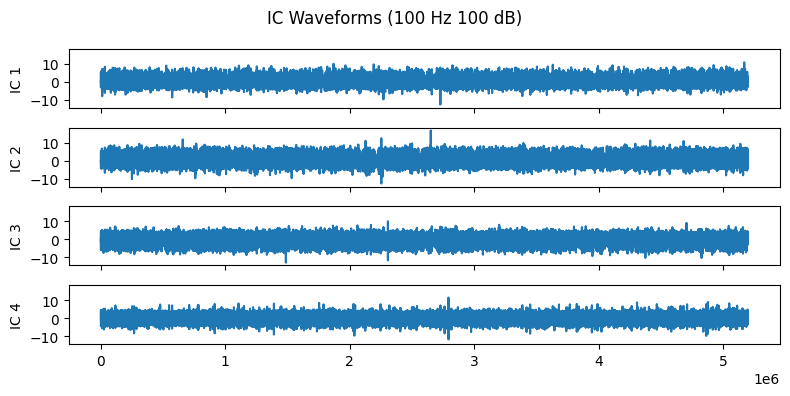

In [19]:
plot_IC_waveforms(ica_results)

In [20]:
len(ica_results['S'][:, 1])

5196744

### Calculate welch's fft of ICs

In [21]:
def compute_welch_fft_IC(data, fs):
    from scipy.signal import welch
    
    component_magnitudes = []
    freq_vecs = []
    
    num_components = data['S'].shape[1]
    for component in range(num_components):
        cur_component = data['S'][:,component]
        n_samples = len(cur_component)
        
        nperseg = 2**np.floor(np.log2(n_samples/2))
        
        # Use default nfft (will be the next power of 2 larger than nperseg)
        freq_vec, Pxx = welch(cur_component, fs=fs, nperseg=nperseg, scaling='spectrum')
        magnitude = np.sqrt(Pxx)
        component_magnitudes.append(magnitude)
        freq_vecs.append(freq_vec)
    
    ICA_welch = {
        'magnitude': np.vstack(component_magnitudes),
        'freq_vector': np.vstack(freq_vecs)
    }                
    return ICA_welch

In [22]:
ICA_welch = compute_welch_fft_IC(ica_results, fs)
# Frequency resolution
np.diff(ICA_welch['freq_vector'][0])[0]

np.float64(0.010514259338378906)

### Plot ffts of ICs

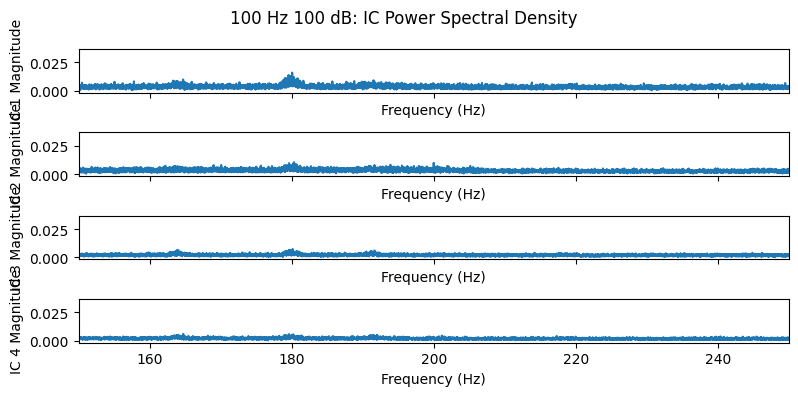

In [23]:
def plot_IC_ffts(ICA_welch, fs, myfreq, myamp,xlim=None):
    # Get the magnitude and frequency vectors
    magnitudes = ICA_welch['magnitude']
    freq_vecs = ICA_welch['freq_vector']
    
    # Determine number of components
    num_components = magnitudes.shape[0]
    
    # Create subplots
    fig, axes = plt.subplots(num_components, 1, figsize=(8, 4), sharex=True, sharey=True)
    
    # Plot each component's FFT
    for row_idx in range(num_components):
        ax = axes[row_idx]
        ax.plot(freq_vecs[row_idx], magnitudes[row_idx])
        ax.set_ylabel(f'IC {row_idx+1} Magnitude')
        ax.set_xlabel('Frequency (Hz)')
        
        # Set x-axis limits if provided
        if xlim is not None:
            ax.set_xlim(xlim)
    
    # Add overall title
    fig.suptitle(f'{myfreq} Hz {myamp} dB: IC Power Spectral Density', fontsize=12)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.savefig(f'{subjid}_IC_FFT_chart.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_IC_ffts(ICA_welch, fs, myfreq, myamp, xlim=(150, 250))

In [24]:
ICA_welch

{'magnitude': array([[3.94228110e-04, 9.07726079e-04, 7.16557819e-04, ...,
         1.88354173e-04, 1.65756247e-04, 6.20471621e-05],
        [2.33695770e-04, 6.82527759e-04, 5.02807971e-04, ...,
         1.13558186e-03, 1.22135632e-03, 6.94843169e-04],
        [1.09051490e-04, 2.47736651e-04, 2.34969461e-04, ...,
         1.02361852e-03, 7.47540365e-04, 8.58349777e-05],
        [2.37488491e-04, 5.76436029e-04, 9.33827012e-04, ...,
         7.74846336e-04, 8.37712017e-04, 6.44265920e-04]],
       shape=(4, 1048577)),
 'freq_vector': array([[0.00000000e+00, 1.05142593e-02, 2.10285187e-02, ...,
         1.10249790e+04, 1.10249895e+04, 1.10250000e+04],
        [0.00000000e+00, 1.05142593e-02, 2.10285187e-02, ...,
         1.10249790e+04, 1.10249895e+04, 1.10250000e+04],
        [0.00000000e+00, 1.05142593e-02, 2.10285187e-02, ...,
         1.10249790e+04, 1.10249895e+04, 1.10250000e+04],
        [0.00000000e+00, 1.05142593e-02, 2.10285187e-02, ...,
         1.10249790e+04, 1.10249895e+04, 

### Determine which ICs have greatest SNR

In [25]:
def select_doub_freq_bin_ICA(data, myfreq):
    # Select double frequency bin
    target_freq = 2*myfreq
    artifact_freqs = [myfreq, target_freq, 60, 120, 180, 240, 300, 360, 420, 480, 540]
    doub_freq_tmp = []
    snr_tmp = []
    
    # Get the magnitude and frequency vectors
    magnitudes = data['magnitude']
    freq_vecs = data['freq_vector']
    
    # Determine number of components
    num_components = magnitudes.shape[0]
    
    for component in range(num_components):
        cur_component = magnitudes[component]
        cur_freq_vec = freq_vecs[component]
        
        # Double frequency mask (3 Hz tolerance)
        doub_mask = np.abs(cur_freq_vec - target_freq) <= 3
        doub_mag = np.mean(cur_component[doub_mask])
        
        # One octave mask (lower and upper bounds)
        octave_mask = (cur_freq_vec >= target_freq/2) & (cur_freq_vec <= target_freq*2)
        
        # Remove artifact frequencies from octave mask
        for freq in artifact_freqs:
            art_mask = np.abs(cur_freq_vec - freq) <= 3
            octave_mask[art_mask] = False
        
        # Calculate remain magnitude
        remain_mag = np.mean(cur_component[octave_mask])
        
        # Calculate SNR
        snr_tmp.append(10 * np.log10((doub_mag) / (remain_mag)))
        doub_freq_tmp.append(doub_mag)
    
    doub_freq_ICA = {
        'doub_freq_mag' : np.hstack(doub_freq_tmp),
        'SNR' : np.hstack(snr_tmp)
    }        
    return doub_freq_ICA

In [26]:
doub_freq_ICA = select_doub_freq_bin_ICA(ICA_welch, myfreq)
doub_freq_ICA

{'doub_freq_mag': array([0.00360821, 0.00371688, 0.00210351, 0.00189461]),
 'SNR': array([0.34821066, 1.24082912, 0.06948268, 0.04151996])}

### Get index values of top 2 components with highest SNR

In [27]:
snr = doub_freq_ICA['SNR']
top2_idx = np.argsort(snr)[-2:][::-1] 
top2_idx

array([1, 0])

### Remove ICs

In [28]:
def remove_and_reconstruct_ica(ica_results, current_cond, channel_keys, components_to_keep):
    recon_restruct_data = {}
    
    # Extract ICA results
    S = ica_results['S']
    A = ica_results['A']
    
    # Create a mask to keep only desired components
    keep_mask = np.zeros(S.shape[1], dtype=bool)
    keep_mask[components_to_keep] = True
    
    # Filter independent components
    S_filtered = S[:, keep_mask]
    A_filtered = A[:, keep_mask]
    
    # Reconstruct the data
    reconstructed_data = np.dot(S_filtered, A_filtered.T)
    
    n_trials = current_cond['ch1'].shape[0]
    n_samples_per_trial = current_cond['ch1'].shape[1]
    
    for idx, channel in enumerate(channel_keys):
        recon_restruct_data[channel] = reconstructed_data[:, idx].reshape(n_trials, n_samples_per_trial)  
    
    return recon_restruct_data, reconstructed_data

In [29]:
recon_restruct_data, reconstructed_data = remove_and_reconstruct_ica(ica_results, current_cond, channel_keys, top2_idx)
recon_restruct_data

{'ch1': array([[ 1.88226345e-04,  1.10089694e-03, -1.33545101e-03, ...,
         -2.39884865e-03, -4.77333911e-03, -6.08659184e-03],
        [ 4.38630473e-04, -2.88331852e-03,  2.37826878e-03, ...,
          2.10332859e-05,  3.03985538e-03,  3.33007030e-03],
        [ 3.69047295e-03, -1.03316455e-03, -2.61809866e-03, ...,
         -1.87044662e-03, -3.00962572e-03, -2.91325893e-05],
        ...,
        [ 4.41380414e-03,  1.53589546e-03, -5.53550963e-04, ...,
          1.49267208e-05,  3.85199184e-03,  3.53536753e-03],
        [ 2.42995025e-04,  1.43925593e-03,  3.60974025e-04, ...,
          4.27980615e-03, -4.90934264e-03, -2.74189423e-03],
        [-1.30865481e-03, -1.84360991e-03, -4.70542162e-03, ...,
         -2.78175269e-03, -1.00080600e-03, -6.04802981e-04]],
       shape=(491, 10584)),
 'ch2': array([[ 0.21459222,  0.06044367, -0.07736794, ..., -0.06082132,
         -0.120073  , -0.2326085 ],
        [ 0.8520429 ,  0.91786544,  0.94459973, ...,  1.19684056,
          1.17018857

### Separate by periods

In [30]:
def separate_periods(current_cond, data, period_keys, channel_keys, latency):
    data = {
        'prestim': {},
        'stimresp': {}
    }
    
    period_len = current_cond['period_len']
    
    for period in period_keys:
        for channel in channel_keys:            
            if period == 'prestim':
                data[period][channel] = recon_restruct_data[channel][:,latency:latency+period_len]
                print(recon_restruct_data[channel].shape)
                print(data[period][channel].shape)
                
            elif period == 'stimresp':
                data[period][channel] = recon_restruct_data[channel][:,latency+period_len:latency+period_len*2]
                
    return data

In [31]:
recon_separate_data = separate_periods(current_cond, recon_restruct_data, period_keys, channel_keys, latency)
recon_separate_data

(491, 10584)
(491, 3528)
(491, 10584)
(491, 3528)
(491, 10584)
(491, 3528)
(491, 10584)
(491, 3528)


{'prestim': {'ch1': array([[ 0.00396734,  0.0028938 ,  0.00400901, ...,  0.00764185,
           0.00957694,  0.01097159],
         [-0.01139527,  0.0096677 , -0.00888557, ...,  0.0018088 ,
          -0.00116983,  0.00120489],
         [ 0.0006693 ,  0.00166449,  0.0009137 , ...,  0.00267295,
          -0.00225428, -0.00614197],
         ...,
         [-0.00175693, -0.00208697, -0.00173531, ..., -0.00062883,
          -0.00246151, -0.00293373],
         [ 0.0021324 ,  0.00138976,  0.00322062, ...,  0.00171592,
           0.00108555,  0.00055624],
         [-0.00020229,  0.00430347, -0.00256446, ...,  0.0025155 ,
           0.00398249,  0.00359295]], shape=(491, 3528)),
  'ch2': array([[ 0.50030776,  0.40734876,  0.53271478, ..., -0.25637019,
          -0.46149637, -0.62183825],
         [-2.20286649, -2.25472719, -2.09349948, ...,  0.84381177,
           0.98414842,  1.2230876 ],
         [ 1.55511731,  1.27472223,  1.27219417, ...,  1.34279728,
           1.42884934,  1.19343801],
    

In [32]:
recon_separate_data

{'prestim': {'ch1': array([[ 0.00396734,  0.0028938 ,  0.00400901, ...,  0.00764185,
           0.00957694,  0.01097159],
         [-0.01139527,  0.0096677 , -0.00888557, ...,  0.0018088 ,
          -0.00116983,  0.00120489],
         [ 0.0006693 ,  0.00166449,  0.0009137 , ...,  0.00267295,
          -0.00225428, -0.00614197],
         ...,
         [-0.00175693, -0.00208697, -0.00173531, ..., -0.00062883,
          -0.00246151, -0.00293373],
         [ 0.0021324 ,  0.00138976,  0.00322062, ...,  0.00171592,
           0.00108555,  0.00055624],
         [-0.00020229,  0.00430347, -0.00256446, ...,  0.0025155 ,
           0.00398249,  0.00359295]], shape=(491, 3528)),
  'ch2': array([[ 0.50030776,  0.40734876,  0.53271478, ..., -0.25637019,
          -0.46149637, -0.62183825],
         [-2.20286649, -2.25472719, -2.09349948, ...,  0.84381177,
           0.98414842,  1.2230876 ],
         [ 1.55511731,  1.27472223,  1.27219417, ...,  1.34279728,
           1.42884934,  1.19343801],
    

### Calculate welch's fft

In [33]:
def compute_welch_fft(data, period_keys, channel_keys, fs):
    from scipy.signal import welch
    freq_step = 1
    pow_two = np.ceil(np.log2(fs/freq_step)) # Compute base 2 logarithm, i.e., what number i need to raise 2 by to get this value. But i wan a whole number so i ceil it
    n_fft = int(2**pow_two) # Nearest power of two for computational efficiency that gives me freq_step of 1 i.e., the total sample length number 
    
    fft_data = {
        'prestim': {},
        'stimresp': {}
    }
        
    for period in period_keys:
        for channel in channel_keys:
            fft_data[period][channel] = {}
            cur_chan = data[period][channel]
            trial_magnitudes = []
            for i_trial in range(cur_chan.shape[0]):
                cur_trial = cur_chan[i_trial]
                n_samples = len(cur_trial)
                nperseg = 2**np.floor(np.log2(n_samples/2))
                
                f, Pxx = welch(cur_trial, fs=fs, nperseg=nperseg, nfft=n_fft, scaling='spectrum')
                
                if period == 'prestim' and channel == 'ch1' and i_trial == 1:
                    freq_vec = f
                
                magnitude = np.sqrt(Pxx)
                trial_magnitudes.append(magnitude)
                
            fft_data[period][channel] = np.vstack(trial_magnitudes)
                
    return fft_data, freq_vec


In [34]:
fft_data_recon, freq_vec_recon = compute_welch_fft(recon_separate_data, period_keys, channel_keys,fs)

In [35]:
fft_data_recon

{'prestim': {'ch1': array([[9.34353912e-05, 1.33328105e-04, 1.36830819e-04, ...,
          1.39818273e-04, 1.39827150e-04, 9.88748564e-05],
         [3.41018498e-04, 4.83610284e-04, 4.87592080e-04, ...,
          1.25694415e-04, 1.25490266e-04, 8.86867502e-05],
         [2.56223579e-04, 3.62855024e-04, 3.64348434e-04, ...,
          8.65019514e-05, 8.65371184e-05, 6.11992840e-05],
         ...,
         [2.59357527e-04, 3.67426817e-04, 3.69335925e-04, ...,
          1.30034260e-04, 1.30001628e-04, 9.19172993e-05],
         [2.90790538e-04, 4.11498735e-04, 4.12273171e-04, ...,
          1.24524088e-04, 1.24603993e-04, 8.81272351e-05],
         [4.26906130e-04, 6.04704973e-04, 6.07596152e-04, ...,
          1.66049123e-04, 1.65928614e-04, 1.17300794e-04]],
        shape=(491, 16385)),
  'ch2': array([[0.16301587, 0.23063975, 0.23094035, ..., 0.00373611, 0.00374008,
          0.00264558],
         [0.18588953, 0.26304441, 0.26351354, ..., 0.00519459, 0.00520126,
          0.00367942],
   

### Plot raw ffts from random trials

In [36]:
def plot_ffts(data, period_keys, channel_keys, subjid, freq_vec, myfreq, myamp, min_x=None, max_x=None):
    import random
    import matplotlib.pyplot as plt
    
    total_trials = len(data['stimresp']['ch1'])
    random_trials = random.sample(range(total_trials), 3)
    
    for random_trial in random_trials:
        # Create a new figure for each trial
        fig, axs = plt.subplots(len(channel_keys), len(period_keys), figsize=(10, 8), sharey=True)
        
        for i, channel in enumerate(channel_keys):
            for j, period in enumerate(period_keys):
                axs[i, j].plot(freq_vec, data[period][channel][random_trial])
                axs[i, j].set_title(f'{channel} - {period}')
                axs[i, j].set_xlabel('Frequency (Hz)')
                axs[i, j].set_ylabel('Magnitude')
                
                # Set x-axis limits if min_x and max_x are provided
                if min_x is not None and max_x is not None:
                    axs[i, j].set_xlim(min_x, max_x)
        
        plt.suptitle(f'{myfreq} Hz {myamp} dB: Welchs ffts for trial {random_trial}')
        plt.tight_layout()
        plt.savefig(f"{subjid}_rand_cum_avg_fft_trial_{random_trial}_{myfreq}Hz_{myamp}dB.png", 
                    format='png', 
                    bbox_inches='tight', 
                    dpi=300)
        plt.show(fig)  # Close the figure after saving

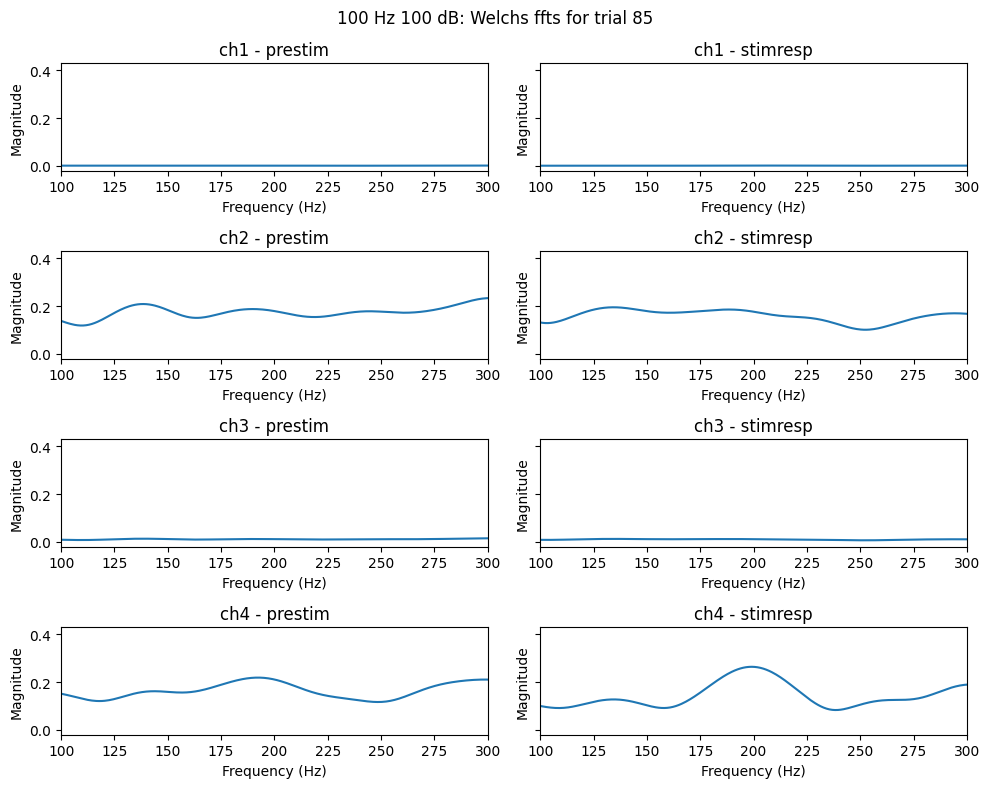

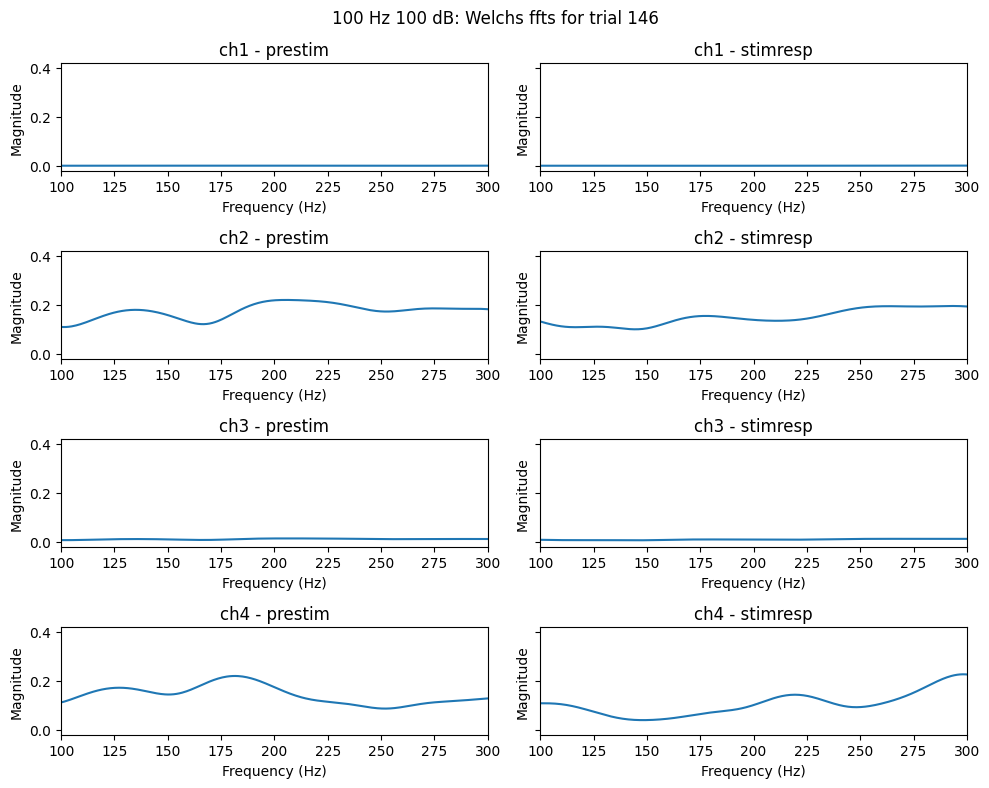

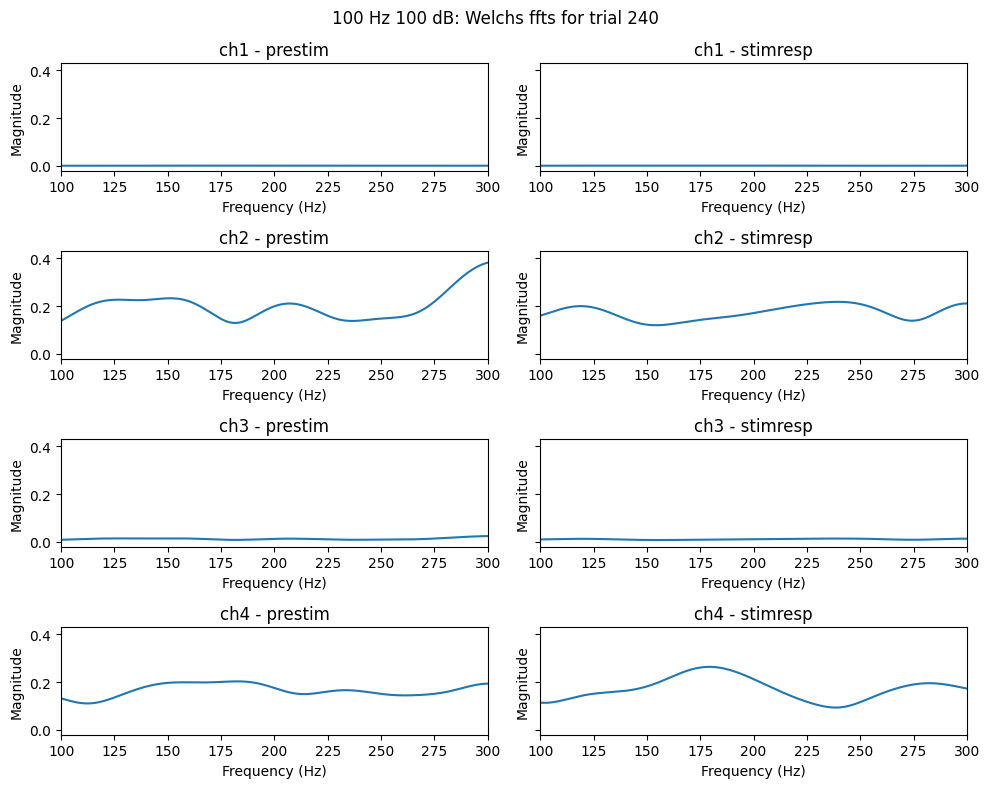

In [37]:
plot_ffts(fft_data_recon, period_keys, channel_keys, subjid, freq_vec_recon, myfreq, myamp, min_x=100, max_x=300)

### Conduct bootstrapped averages (defunct)

In [38]:
def create_bootstrap_distribution(fft_data, period_keys, channel_keys, fs, 
                                  n_samples=1000, 
                                  sample_fraction=0.75, 
                                  random_seed=None):
    # Set random seed for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Initialize storage
    bootstrap_data = {period: {ch: {'mean': [], 'variance': [], 'std': []}
                      for ch in channel_keys}
                      for period in period_keys}
    
    
    # Assume all periods have same number of trials per channel
    example_period = period_keys[0]
    example_channel = channel_keys[0]
    total_trials = len(fft_data[example_period][example_channel])
    sample_size = int(total_trials * sample_fraction)
    
    # Perform bootstrap sampling
    bootstrap_means = []
    bootstrap_variances = []
    bootstrap_stds = []
    
    for _ in range(n_samples):
        # Ensure consistent sampling size
        bootstrap_indices = np.random.choice(
            total_trials, 
            size=sample_size, 
            replace=True
        )
        
        ## Debug
        # print('Bootstrap indices')
        # print(bootstrap_indices)
        # print(f"Data array shape:{np.array(bootstrap_indices.shape)}")
        
        for period in period_keys:
            for channel in channel_keys:
                bootstrap_data[period][channel] = {
                    'mean': [],
                    'variance': [],
                    'std': []
                }
            
                data_array = fft_data[period][channel]
                ## Debug
                # print('Data array')
                # print(data_array)
                # print(f"Data array shape:{np.array(data_array.shape)}")
                
                bootstrap_sample = data_array[bootstrap_indices]
                ## Debug
                # print(f"bootstrap sample: {bootstrap_sample}")
                # print(f"bootstrap sample shape: {np.array(bootstrap_sample).shape}")

                bootstrap_data[period][channel]['mean'].append(np.mean(bootstrap_sample, axis=0))
                bootstrap_data[period][channel]['variance'].append(np.var(bootstrap_sample, axis=0))
                bootstrap_data[period][channel]['std'].append(np.std(bootstrap_sample, axis=0))
                
                # Compute statistics for this bootstrap sample
                bootstrap_means.append(np.mean(bootstrap_sample, axis=0))
                ## Debug
                # print('Bootstrap means')
                # print(np.array(bootstrap_means))
                # print(f"bootstrap means shape: {np.array(bootstrap_means).shape}")
                bootstrap_variances.append(np.var(bootstrap_sample, axis=0))
                bootstrap_stds.append(np.std(bootstrap_sample, axis=0))
    
     # Convert lists to numpy arrays
    for period in period_keys:
        for channel in channel_keys:
            for stat in ['mean', 'variance', 'std']:
                bootstrap_data[period][channel][stat] = np.array(bootstrap_data[period][channel][stat])

    return bootstrap_data

In [39]:
bootstrap_data = create_bootstrap_distribution(fft_data, period_keys, channel_keys, fs, n_samples=100
,sample_fraction=0.75, random_seed=1)

NameError: name 'fft_data' is not defined

### Conduct cumulative averaging (defunct)

In [ ]:
def compute_cumulative_avg(fft_data, period_keys, channel_keys, fs, keep_last):
### Hmm still need to learn about computationally efficient variance calculations
    cumu_data = {
        'prestim': {},
        'stimresp': {}
    }
    
    for period in period_keys:
        for channel in channel_keys:
            cumu_data[period][channel] = {
                'mean': [],
                'variance': [],
                'std': []
            }

            data_array = fft_data[period][channel]         
            trial_count_vector = np.arange(1, len(data_array) + 1)
            
            cumu_mean = np.cumsum(data_array, axis=0) / np.arange(1, len(data_array) + 1)[:, np.newaxis]
            cumu_variance = (np.cumsum(data_array**2, axis=0) / np.arange(1, len(data_array) + 1)[:, np.newaxis]) - (cumu_mean**2)
            cumu_std = np.sqrt(cumu_variance)
            
            cumu_data[period][channel]['mean'] = cumu_mean[-keep_last:]
            cumu_data[period][channel]['variance'] = cumu_variance[-keep_last:]
            cumu_data[period][channel]['std'] = cumu_std[-keep_last:]
    
    return cumu_data, trial_count_vector

### Plot FFTs

In [ ]:
def plot_cumulative_ffts(data, period_keys, channel_keys, subjid, freq_vec, myfreq, myamp, x_min=None, x_max=None):
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, axs = plt.subplots(len(channel_keys), len(period_keys), figsize=(10, 8), sharey=True)
    
    for i, channel in enumerate(channel_keys):
        for j, period in enumerate(period_keys):
            # Get the cumulative mean and standard deviation
            mean = data[period][channel]['mean'][-1]  # Last cumulative mean
            std = data[period][channel]['std'][-1]    # Last cumulative standard deviation
            
            # Plot the mean
            axs[i, j].plot(freq_vec, mean, label='Mean')
            
            # Add shaded area for +1 standard deviation
            axs[i, j].fill_between(freq_vec, 
                                   mean, 
                                   mean + std, 
                                   alpha=0.3, 
                                   label='+1 Std Dev')
            
            axs[i, j].set_title(f'{channel} - {period}')
            axs[i, j].set_xlabel('Frequency (Hz)')
            axs[i, j].set_ylabel('Magnitude')
            axs[i, j].legend()
            
            # Set x-axis limits if provided
            if x_min is not None and x_max is not None:
                axs[i, j].set_xlim(x_min, x_max)
    
    plt.suptitle(f'{myfreq} Hz {myamp} dB: Cumulative Average FFTs')
    plt.tight_layout()
    
    plt.savefig(f"{subjid}_last_cum_avg_fft_{myfreq}Hz_{myamp}dB.png", 
                format='png', 
                bbox_inches='tight', 
                dpi=300)
    
    plt.show()


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

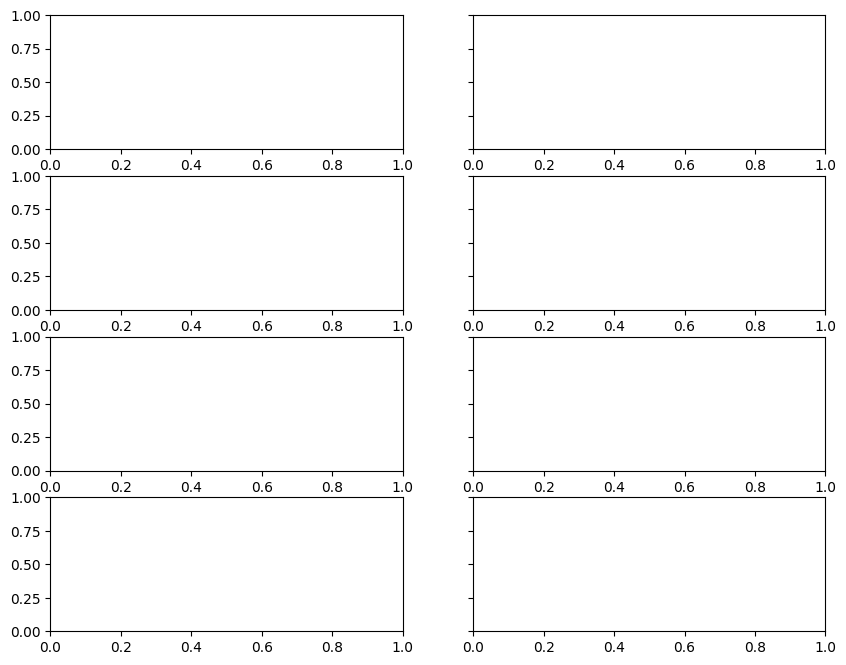

In [ ]:
plot_cumulative_ffts(fft_data, period_keys, channel_keys, subjid, freq_vec, myfreq, myamp, x_min=100, x_max=300)

### Select the double frequency response

In [ ]:
len(fft_data_recon['stimresp']['ch1'])

97

In [ ]:
freq_vec_recon

array([0.00000000e+00, 6.72912598e-01, 1.34582520e+00, ...,
       1.10236542e+04, 1.10243271e+04, 1.10250000e+04], shape=(16385,))

In [ ]:
def select_doub_freq_bin_ICA(data, freq_vec, myfreq, period_keys, channel_keys):
    # Select double frequency bin
    target_freq = 2*myfreq
    artifact_freqs = [myfreq, target_freq, 60, 120, 180, 240, 300, 360, 420, 480, 540]
    
    doub_freq_recon = {period: {channel: {} for channel in channel_keys} for period in period_keys}
    
    for period in period_keys:
        for channel in channel_keys:
            doub_freq_tmp = []
            snr_tmp = []
        # Get the magnitude and frequency vectors
            magnitudes = data[period][channel]
            noise_floor = data['stimresp'][channel]
            # Determine number of trials
            num_trials = magnitudes.shape[0]
            
            for trial in range(num_trials):
                cur_component = magnitudes[trial]
                cur_noise_floor = noise_floor[trial]
                
                # Double frequency mask (3 Hz tolerance)
                doub_mask = np.abs(freq_vec - target_freq) <= 3
                doub_mag = np.mean(cur_component[doub_mask])
                
                # One octave mask (lower and upper bounds)
                octave_mask = (freq_vec >= target_freq/2) & (freq_vec <= target_freq*2)
                
                # Remove artifact frequencies from octave mask
                for freq in artifact_freqs:
                    art_mask = np.abs(freq_vec - freq) <= 3
                    octave_mask[art_mask] = False
                
                # Calculate remain magnitude
                # remain_mag = np.mean(cur_component[octave_mask]) Decide which
                remain_mag = np.mean(cur_noise_floor[octave_mask])
                
                # Calculate SNR
                snr_tmp.append(10 * np.log10((doub_mag) / (remain_mag)))
                doub_freq_tmp.append(doub_mag)
            
            doub_freq_recon[period][channel] = {
                'doub_freq_mag' : np.hstack(doub_freq_tmp),
                'SNR' : np.hstack(snr_tmp)
            }    
                
    return doub_freq_recon

In [54]:
doub_freq_recon = select_doub_freq_bin_ICA(fft_data_recon, freq_vec_recon, myfreq, period_keys, channel_keys)

### Check to see if std value is completely nuts (after taking average of all trials...)

In [ ]:
def find_large_stds(data, period_keys, channel_keys, metric_keys):
    my_rat_data = {}
    for channel in channel_keys.copy():
        my_rat_data[channel] = []
        my_mean = data['stimresp'][channel]['mean']['doub_freq_mag'][-1] # whatever trial...
        my_std = data['stimresp'][channel]['std']['doub_freq_mag'][-1]
        my_rat = my_std/my_mean
        my_rat_data[channel].append(my_rat)
        
        print(f"{channel} : {my_rat}")
    
        if my_rat > 6:
            print(f"Warning {channel} has super high std value")
            
    filt_channel_keys = channel_keys

    return my_rat_data, filt_channel_keys


In [ ]:
my_rat_data, filt_channel_keys = find_large_stds(doub_freq_data, period_keys, channel_keys, metric_keys)    

ch1 : 0.525197836903635
ch2 : 0.5455569028683511
ch3 : 0.4867690864498779
ch4 : 0.4988842424285428


### Power analysis (?)

### Histogram code

In [55]:
doub_freq_recon

{'prestim': {'ch1': {'doub_freq_mag': array([0.000667  , 0.00078266, 0.00098556, 0.00120704, 0.00063784,
          0.00066885, 0.00070388, 0.00060132, 0.00078572, 0.00098291,
          0.00100934, 0.00051888, 0.00100176, 0.00067422, 0.00101611,
          0.00048002, 0.00054702, 0.0008739 , 0.00068091, 0.00063176,
          0.00049134, 0.00058543, 0.00068826, 0.00099685, 0.00063087,
          0.00072575, 0.000771  , 0.00081968, 0.00071781, 0.00072754,
          0.00053159, 0.00071501, 0.00089954, 0.00078815, 0.00068327,
          0.000692  , 0.00085181, 0.00091223, 0.00053688, 0.00047873,
          0.00066721, 0.00141193, 0.00050551, 0.00094572, 0.00097432,
          0.00058112, 0.00083365, 0.00053381, 0.00055229, 0.00062626,
          0.00074446, 0.00078959, 0.00056147, 0.00083723, 0.00082507,
          0.00058471, 0.00051587, 0.00084704, 0.00053601, 0.00084788,
          0.0006487 , 0.00083064, 0.00082578, 0.00049476, 0.00078578,
          0.0006553 , 0.00095512, 0.00095666, 0.0006802

In [56]:
def plot_hist(data, subjid, channel_keys, submetric_keys, myfreq, myamp, bin_num):
    for submetric in submetric_keys:
        # Create the figure for each submetric
        fig, axes = plt.subplots(4, 2, figsize=(15, 20), sharex=True, sharey=True)
        
        # Iterate through channels
        for i, channel in enumerate(channel_keys):
            prestim = data['prestim'][channel][submetric]
            stimresp = data['stimresp'][channel][submetric]
            
            # Prestim (Stim OFF) histogram
            axes[i, 0].hist(prestim, 
                            bins=bin_num, edgecolor='black')
            axes[i, 0].set_title(f'{channel} Stim OFF - {submetric}')
            axes[i, 0].set_xlabel('Power')
            axes[i, 0].set_ylabel('Frequency')
            axes[i, 0].set_yscale('log')
            
            # Stimresp (Stim ON) histogram
            axes[i, 1].hist(stimresp, 
                            bins=bin_num, edgecolor='black')
            axes[i, 1].set_title(f'{channel} Stim ON - {submetric}')
            axes[i, 1].set_xlabel('Power')
            axes[i, 1].set_ylabel('Frequency')
            axes[i, 1].set_yscale('log')
        
        # Overall figure title
        fig.suptitle(f"{subjid} 2x Freq. Resp. {submetric} Comparison {myfreq}Hz {myamp}dB", 
                    fontsize=16)
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save figure
        plt.savefig(f"{subjid}_2x_resp_hist_{submetric}_{myfreq}Hz_{myamp}dB.png", 
                    format='png', 
                    bbox_inches='tight', 
                    dpi=300)
        
        # Show the plot and keep it open
        plt.show()

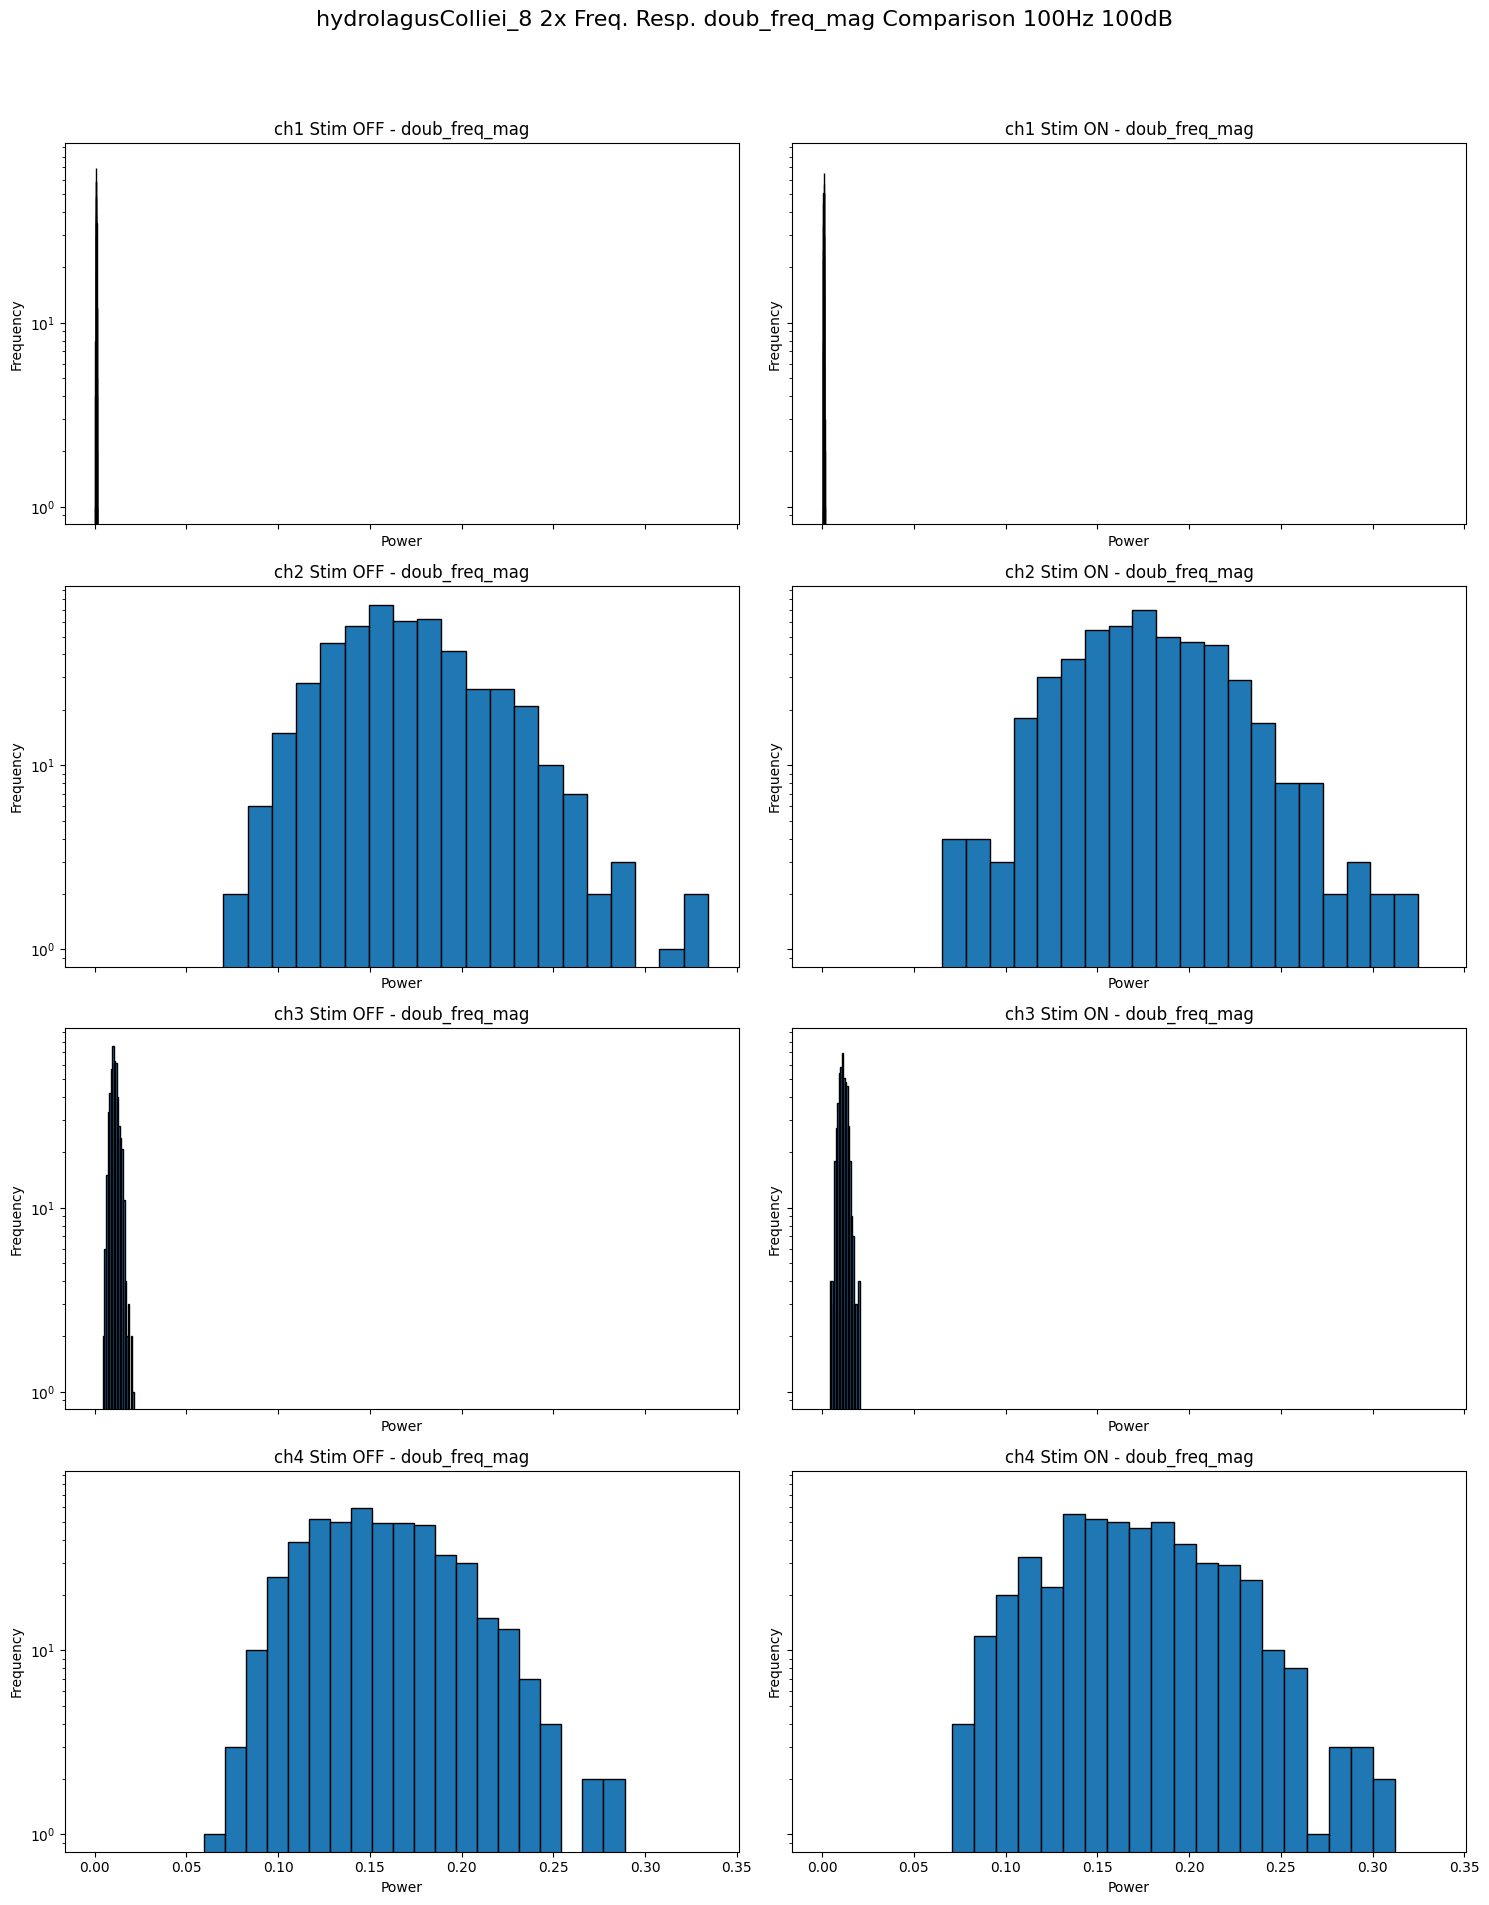

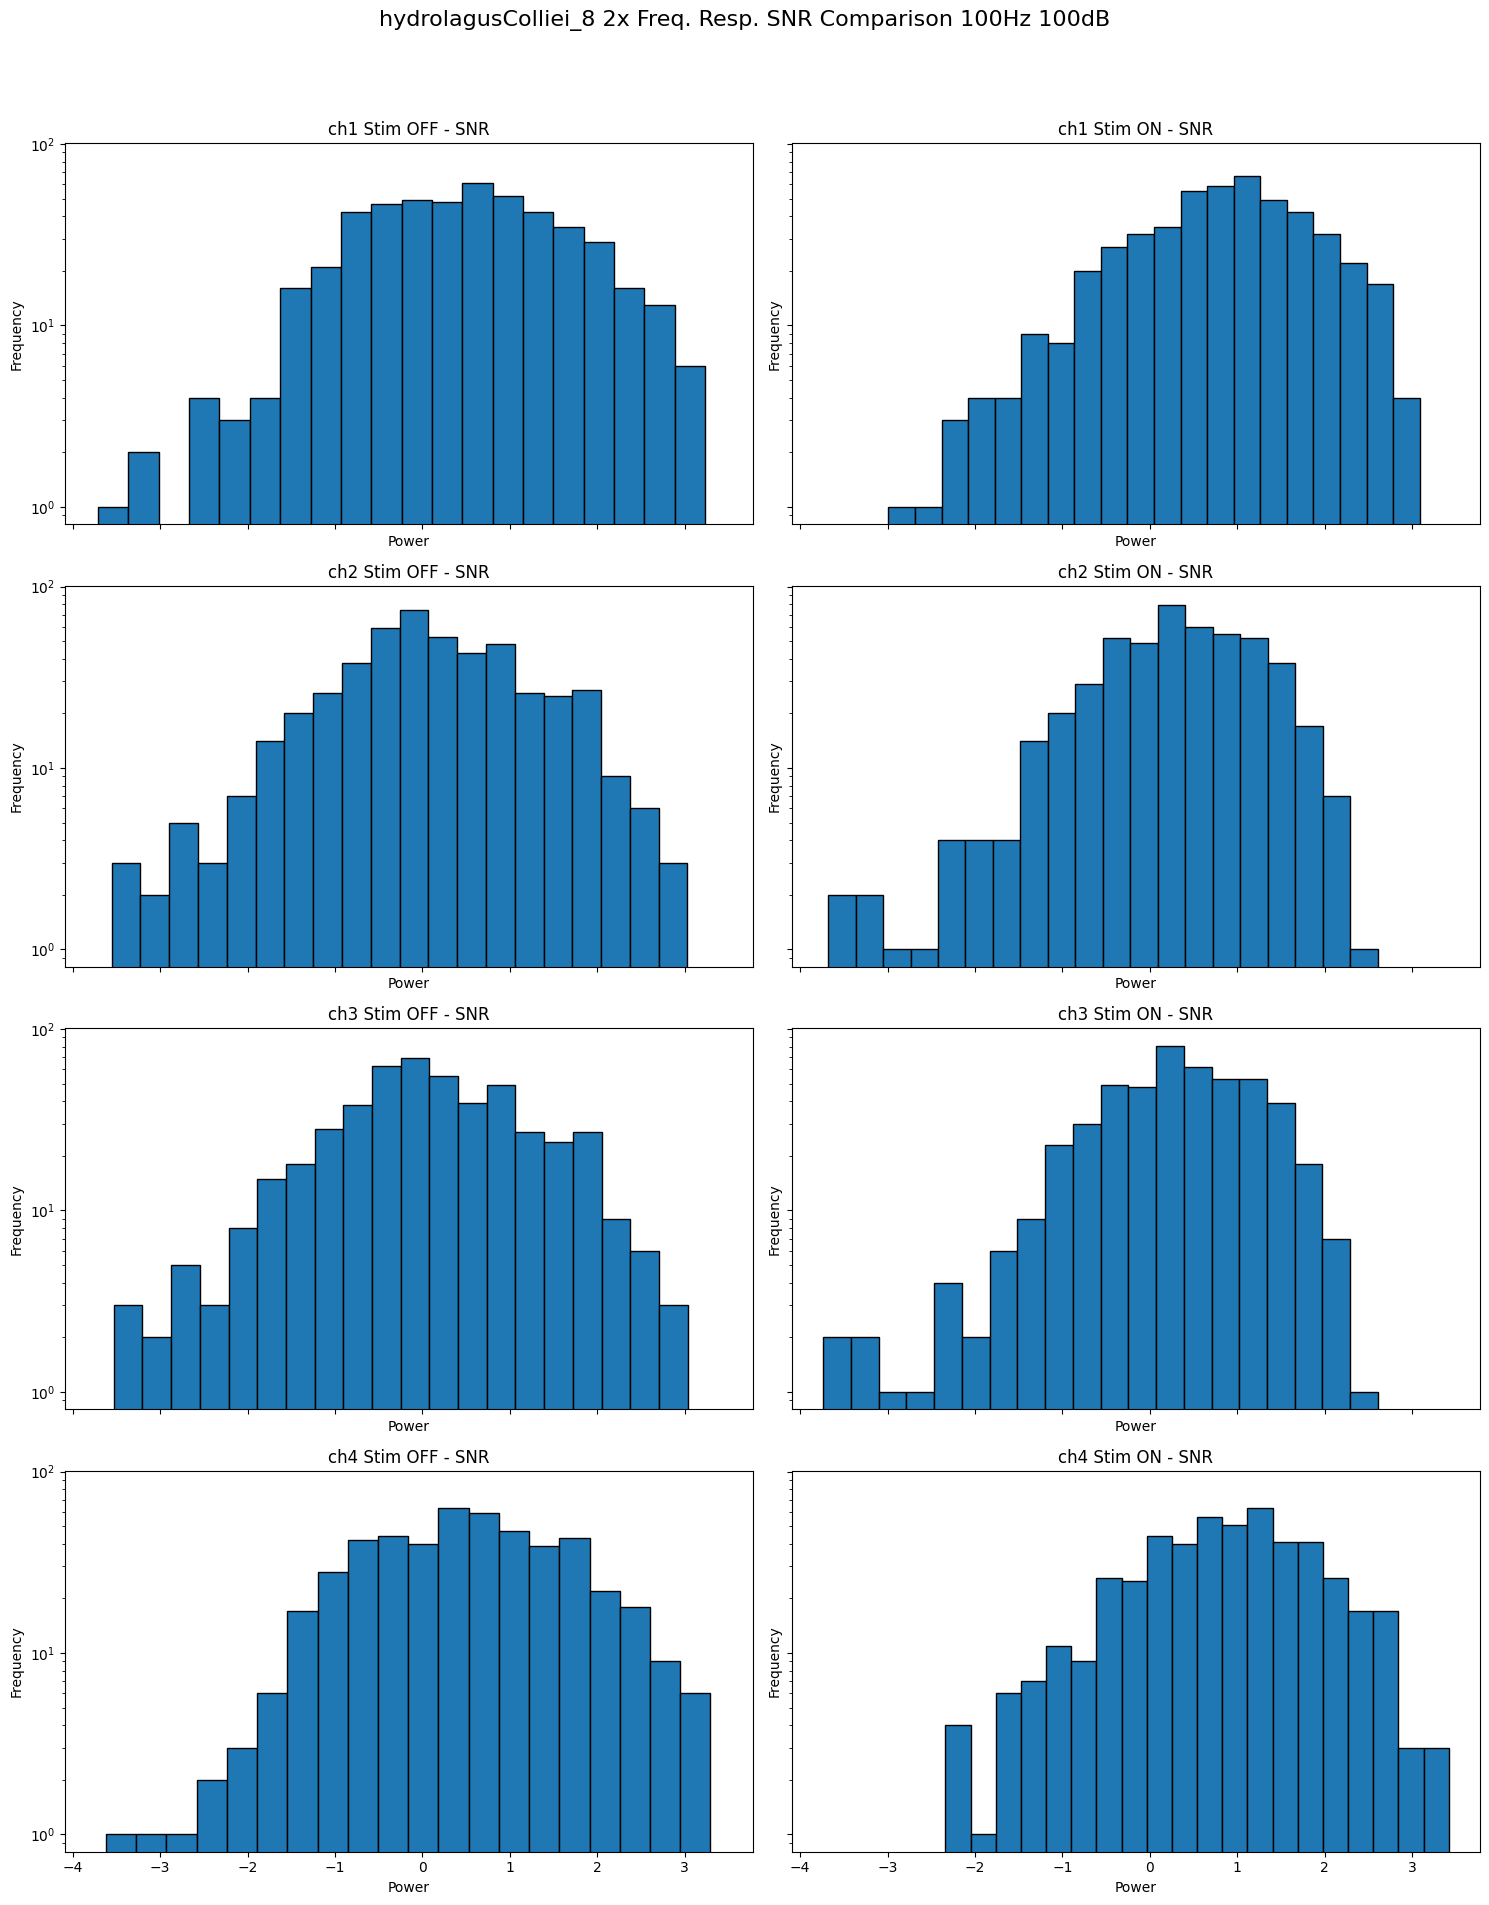

In [57]:
plot_hist(doub_freq_recon, subjid, channel_keys, submetric_keys, myfreq, myamp,20)

### Wilcoxon

In [46]:
def calc_wilcoxon(data, channel_keys, metric):
    results = {}
    for channel in channel_keys:
        prestim = data['prestim'][channel][metric]
        stimresp = data['stimresp'][channel][metric]
        stat, p_value = wilcoxon(prestim, stimresp)
        
        # Calculate paired differences
        differences = stimresp - prestim
        mean_difference = np.mean(differences)  # negative means prestim is larger
        
        results[channel] = {
            'statistic': stat,
            'p_value': p_value,
            'mean_difference': mean_difference
        }
    
    return results

In [58]:
wilcox_doub_freq_mag = calc_wilcoxon(doub_freq_recon, channel_keys, 'doub_freq_mag')
wilcox_SNR = calc_wilcoxon(doub_freq_recon, channel_keys, 'SNR')
pd.DataFrame(wilcox_SNR)

,ch1,ch2,ch3,ch4
statistic,45705.000000,49991.000000,50006.000000,45100.000000
p_value,0.000003,0.000943,0.000959,0.000001
mean_difference,0.336965,0.196450,0.195539,0.347221


### Permutation test

In [48]:
import numpy as np
from scipy import stats

def calc_paired_perm(data, channel_keys, metric, n_resamples):
    # Validate input
    if 'prestim' not in data or 'stimresp' not in data:
        raise ValueError("Data must contain 'prestim' and 'stimresp' keys")
    
    results = {}
    
    for channel in channel_keys:
        # Extract data for the specific metric and channel
        prestim = data['prestim'][channel][metric]
        stimresp = data['stimresp'][channel][metric]
        
        # Perform permutation test
        def statistic(x, y):
            return np.median(x) - np.median(y)
        
        result = stats.permutation_test(
            (prestim, stimresp), 
            statistic, 
            n_resamples=n_resamples,  # Use the input parameter
            vectorized=False,
            alternative='two-sided'
        )
        
        # Store results for each channel
        results[channel] = {
            'statistic': result.statistic,  # Observed difference in means
            'p_value': result.pvalue,       # P-value from the test
            'null_distribution': result.null_distribution  # Distribution of permuted differences
        }
    
    return results

In [49]:
perm_doub_freq_mag = calc_paired_perm(doub_freq_recon, channel_keys, 'doub_freq_mag', n_resamples=10000)
perm_SNR = calc_paired_perm(doub_freq_recon, channel_keys, 'SNR', n_resamples=10000)
pd.DataFrame(perm_SNR)

,ch1,ch2,ch3,ch4
statistic,-0.36056,-0.211359,-0.20795,-0.305176
p_value,0.0002,0.0032,0.0032,0.0002
null_distribution,"[0.06756315497302756, 0.011765464480147036, 0....","[0.030228826184607926, 0.10538278372517512, -0...","[0.14021329991949394, 0.0517465121839924, -0.1...","[0.006554153364198179, 0.15060195204154037, -0..."


In [50]:
from scipy.stats import ttest_rel

metric = 'SNR'
for channel in channel_keys:
    pre = doub_freq_recon['prestim'][channel][metric]
    post = doub_freq_recon['stimresp'][channel][metric]

    stat, p = ttest_rel(post, pre)
    print(channel)
    print(stat)
    print(p)


ch1
4.8415402586989735
1.7299006875362843e-06
ch2
3.0330587672092197
0.002549293570575787
ch3
3.015637146329576
0.0026975344929630845
ch4
5.097281407523015
4.92969299161154e-07


## Check if wilcoxon is reasonable (i.e., sign reversal based)
Wilcoxon ranks the absolute values of stimresp - prestim within each pair.
It then sums the ranks of positive and negative differences.

If all your differences have the same sign (e.g., every stimresp > prestim), then:

All signed ranks go in one direction.

The Wilcoxon statistic = 0 (or N(N+1)/2 for the other side, depending on implementation).

The p-value will be extremely small (like 1.4e-34), indicating a systematic shift.

So even if one metric has an average change of +0.02 and the other +1.30,
if all the paired differences are positive in both, you’ll get the same statistic and p-value.

In [51]:
diff1 = collapsed_data['stimresp']['doub_freq_mag'] - collapsed_data['prestim']['doub_freq_mag']
diff2 = collapsed_data['stimresp']['SNR'] - collapsed_data['prestim']['SNR']

np.sign(diff1)
np.sign(diff2)


NameError: name 'collapsed_data' is not defined

## Colored histogram by average trial num

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def color_hist_bars(ax, data, num_bins, vmin=None, vmax=None):
    # Compute histogram and bin edges
    counts, edges = np.histogram(data, bins=num_bins)
    
    # Initialize an array to store average values for each bin
    bin_averages = np.zeros_like(counts, dtype=float)
    
    # Calculate average value for each bin
    for i in range(len(edges) - 1):
        # Find trials falling in this bin
        bin_mask = (data >= edges[i]) & (data < edges[i+1])
        
        # If no trials in this bin, average remains 0
        if np.sum(bin_mask) > 0:
            bin_averages[i] = np.mean(data[bin_mask])
    
    # If vmin and vmax are not provided, use the min and max of this data
    if vmin is None:
        vmin = bin_averages.min()
    if vmax is None:
        vmax = bin_averages.max()
    
    # Create color map
    norm = plt.Normalize(vmin, vmax)
    colors = cm.viridis(norm(bin_averages))
    
    # Plot histogram with color-coded bars
    ax.bar(edges[:-1], counts, width=np.diff(edges), align='edge', 
        color=colors, edgecolor='black', linewidth=1, alpha=0.7)
    
    # Add colorbar
    sm = cm.ScalarMappable(cmap=cm.viridis, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Average Value')
    
    return vmin, vmax

def plot_collapsed_color_hist(data, subjid, channel_keys, submetric_keys, myfreq, myamp, num_bins):
    for submetric in submetric_keys:
        # Create the figure for each submetric
        fig, axes = plt.subplots(4, 2, figsize=(15, 20), sharex=True, sharey=True)
        
        # Find global min and max for consistent color scaling
        all_prestim = np.concatenate([data['prestim'][channel]['mean'][submetric] for channel in channel_keys])
        all_stimresp = np.concatenate([data['stimresp'][channel]['mean'][submetric] for channel in channel_keys])
        global_min = min(np.min(all_prestim), np.min(all_stimresp))
        global_max = max(np.max(all_prestim), np.max(all_stimresp))
        
        # Iterate through channels
        for i, channel in enumerate(channel_keys):
            # Prestim (Stim OFF) histogram
            vmin, vmax = color_hist_bars(axes[i, 0], 
                                         data['prestim'][channel]['mean'][submetric], 
                                         num_bins,
                                         vmin=global_min, 
                                         vmax=global_max)
            axes[i, 0].set_title(f'{channel} Stim OFF - {submetric}')
            axes[i, 0].set_xlabel('Power')
            axes[i, 0].set_ylabel('Frequency')
            axes[i, 0].set_yscale('log')
            
            # Stimresp (Stim ON) histogram
            color_hist_bars(axes[i, 1], 
                            data['stimresp'][channel]['mean'][submetric],
                            num_bins, 
                            vmin=vmin, 
                            vmax=vmax)
            axes[i, 1].set_title(f'{channel} Stim ON - {submetric}')
            axes[i, 1].set_xlabel('Power')
            axes[i, 1].set_ylabel('Frequency')
            axes[i, 1].set_yscale('log')
        
        # Overall figure title
        fig.suptitle(f"{subjid} 2x Freq. Resp. {submetric} Comparison {myfreq}Hz {myamp}dB", 
                    fontsize=16)
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save figure
        plt.savefig(f"{subjid}_2x_resp_color_hist_{submetric}_{myfreq}Hz_{myamp}dB.png", 
                    format='png', 
                    bbox_inches='tight', 
                    dpi=300)
        
        # Show the plot 
        plt.show()

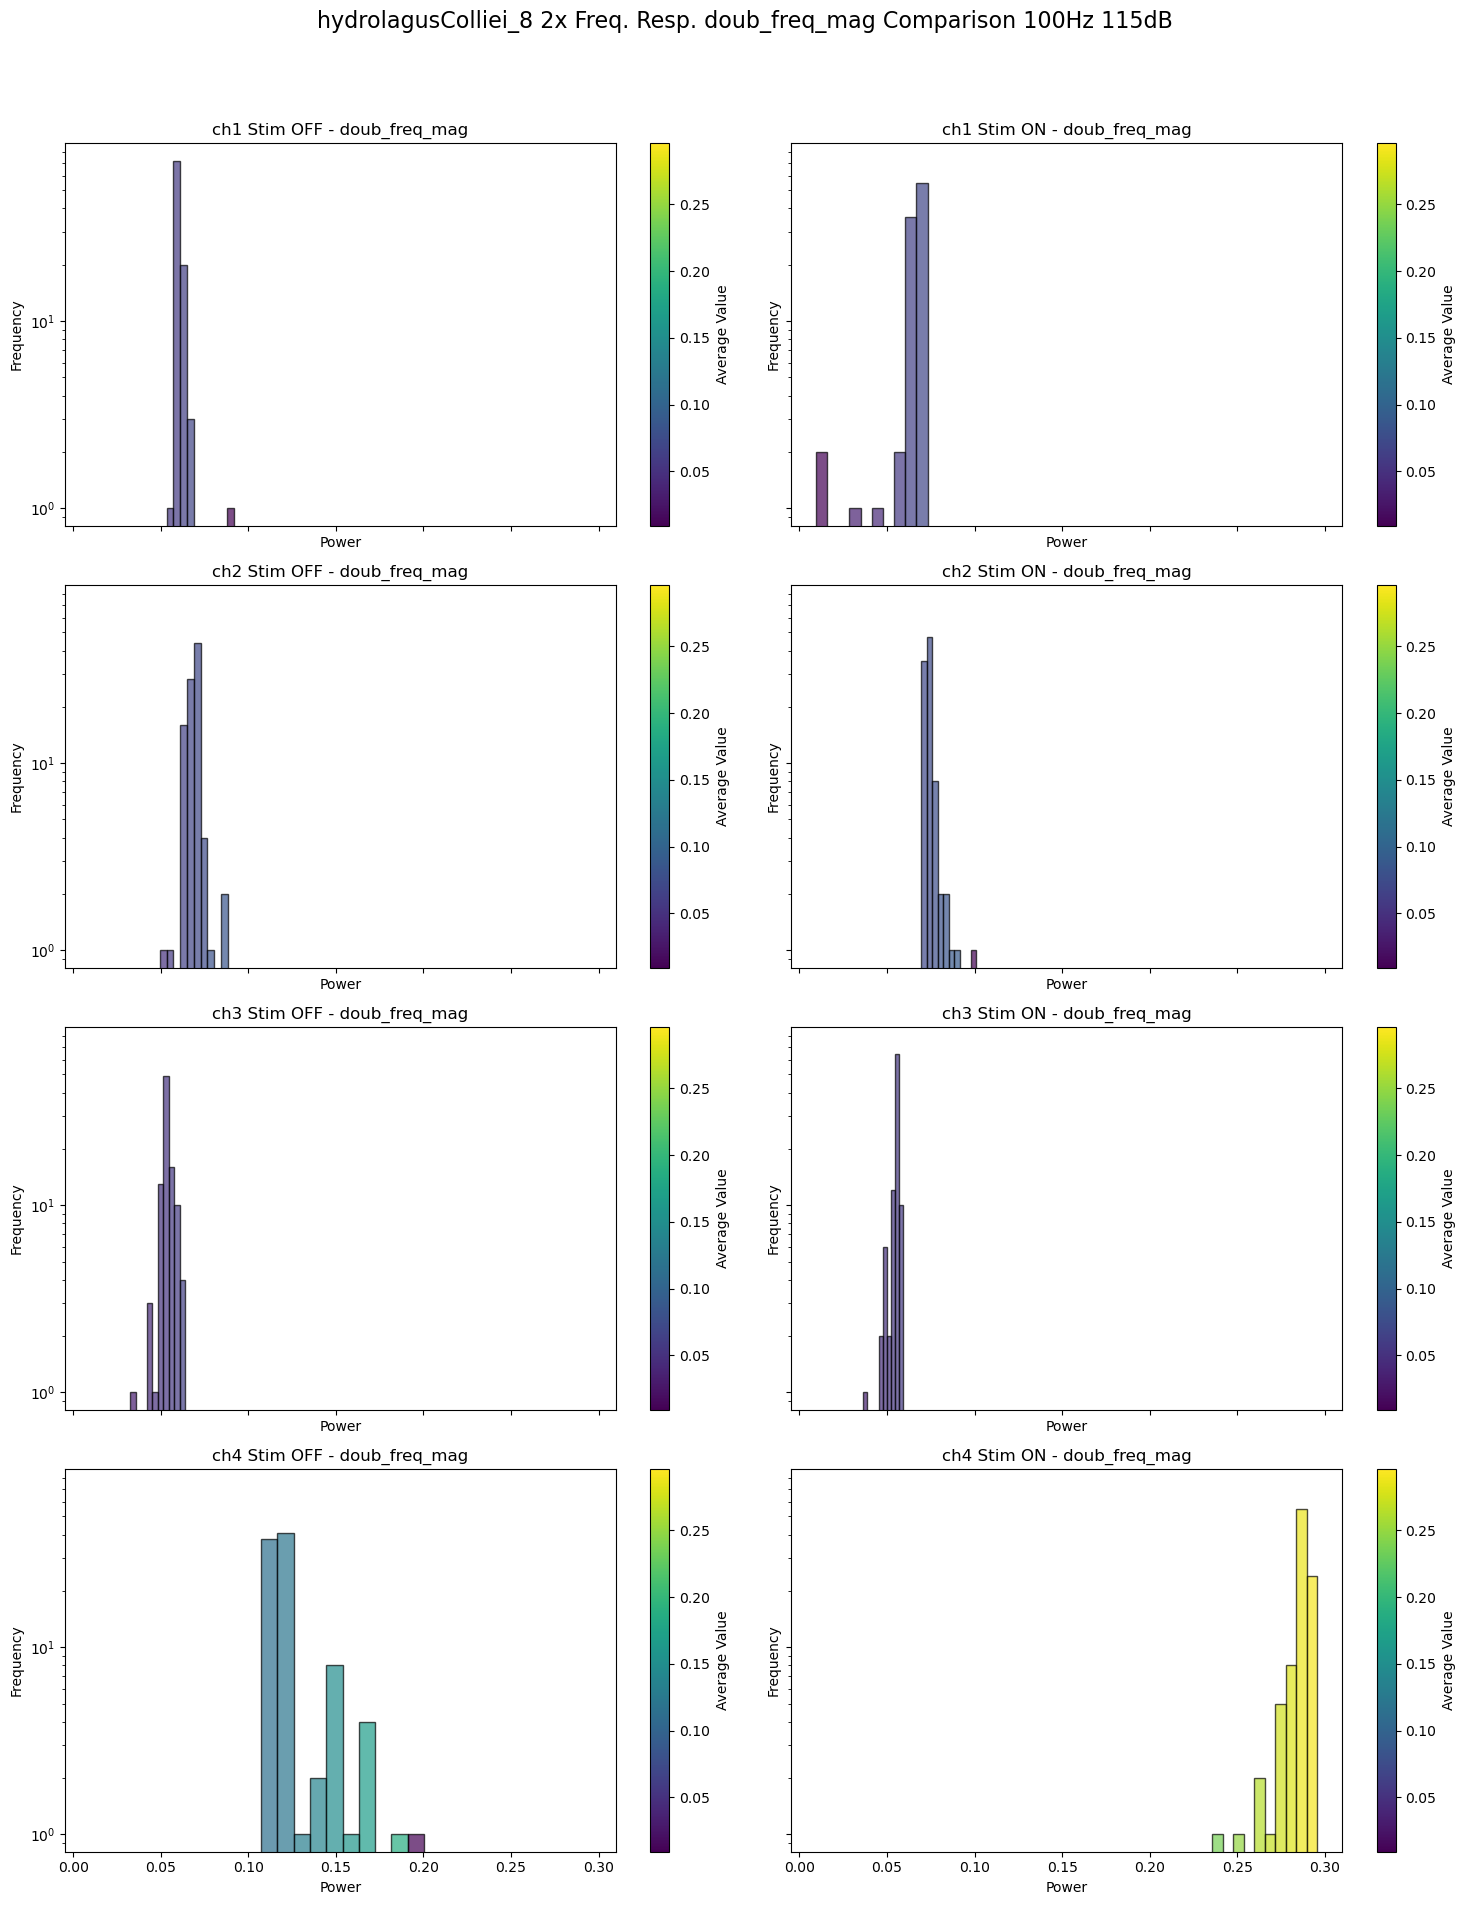

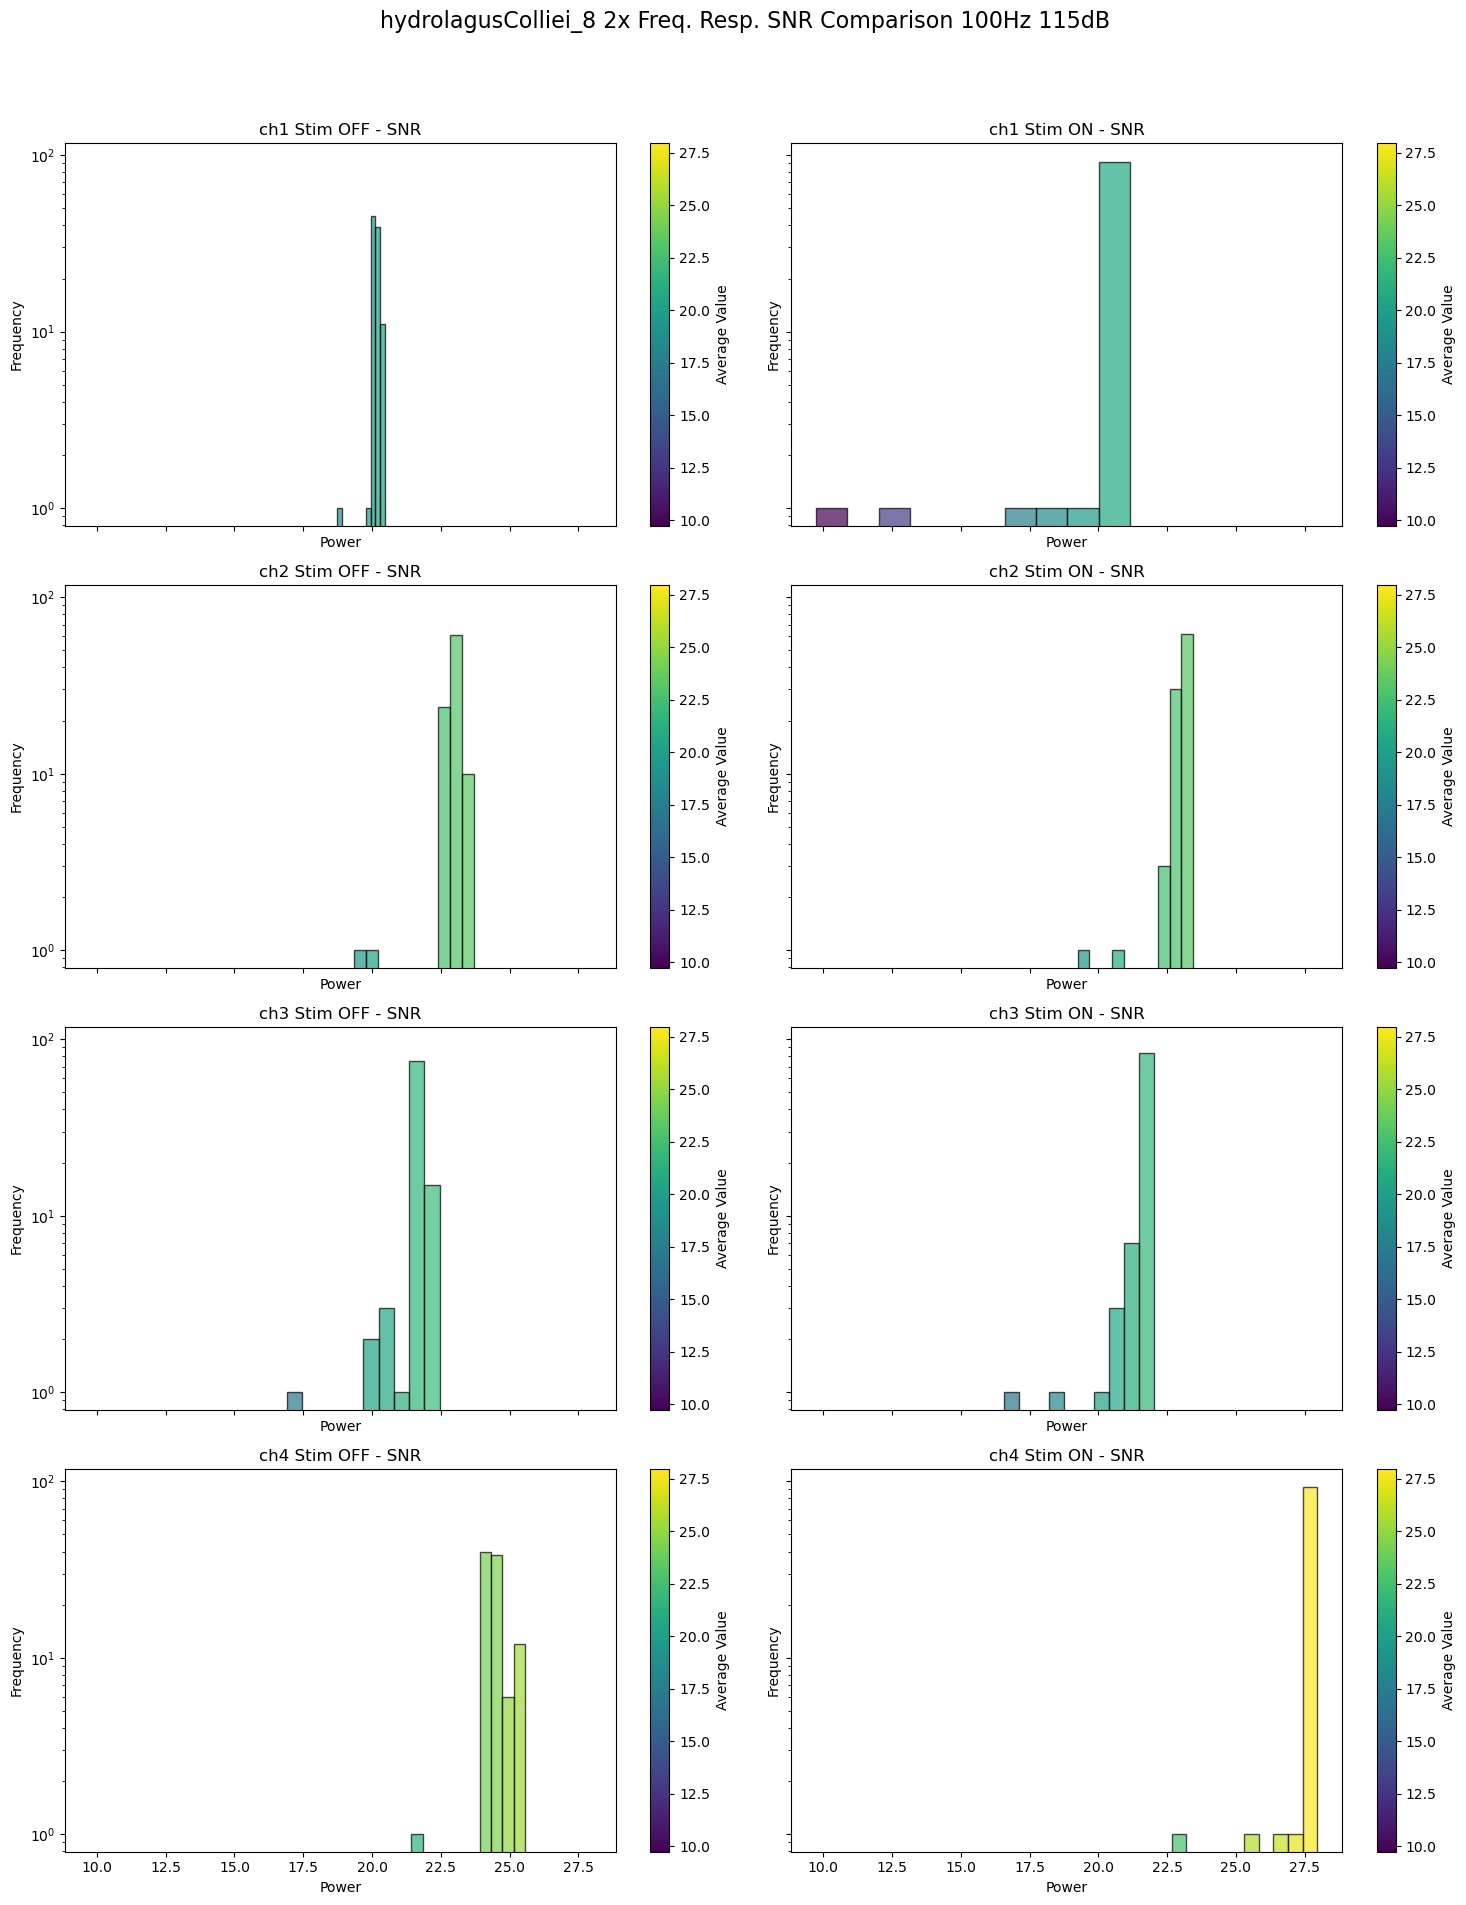

In [ ]:
plot_collapsed_color_hist(doub_freq_data, subjid, channel_keys, submetric_keys, myfreq, myamp, 10)

### Scatter plot with std info included

In [ ]:
def plot_mean_std_scatter(data, subjid, myfreq, myamp, metric_1, metric_2):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

    # First subplot
    ax1.grid(alpha=0.3)
    ax1.scatter(data['prestim'][metric_1], data['prestim'][metric_2], alpha=0.7)
    ax1.set_title('Subplot 1')
    ax1.set_xlabel('Mean')
    ax1.set_ylabel('STD')

    # Second subplot
    ax2.grid(alpha=0.3)
    ax2.scatter(data['stimresp'][metric_1], data['stimresp'][metric_2], color='orange', alpha=0.7)
    ax2.set_title('Subplot 2')
    ax2.set_xlabel('Mean')
    ax2.set_ylabel('STD')

    # Add an overall title
    fig.suptitle(f'{subjid} {myfreq} Hz {myamp} dB: 2x Freq. Resp Mean vs. STD Across Cumulative Averages')

    # Adjust layout and show
    plt.tight_layout()
    plt.savefig(f"{subjid}_2x_resp_scatter_{myfreq}Hz_{myamp}dB.png", 
                format='png', 
                bbox_inches='tight', 
                dpi=300)
    plt.show()


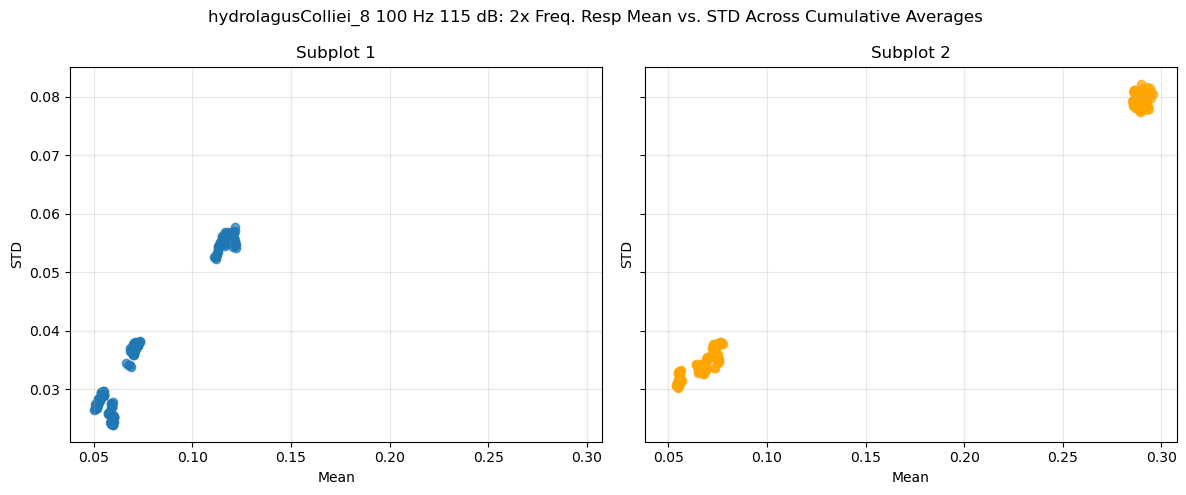

In [ ]:
plot_mean_std_scatter(collapsed_data, subjid, myfreq, myamp, 'doub_freq_mag', 'doub_freq_mag_std')

### Box and whisker plots

In [ ]:
def plot_box_whisker(data, subjid, myfreq, myamp, metric):
    # Create the figure with one row, two columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    # Boxplot for pre-stimulus
    ax1.boxplot(data['prestim'][metric], vert=True, patch_artist=True)
    ax1.set_title('Stim OFF')
    ax1.set_ylabel('Power')
    ax1.set_xticks([1])
    ax1.set_xticklabels(['Pre-Stim'])

    # Boxplot for stimulus response
    ax2.boxplot(data['stimresp'][metric], vert=True, patch_artist=True)
    ax2.set_title('Stim ON')
    ax2.set_xticks([1])
    ax2.set_xticklabels(['Stim Resp'])

    # Add an overall title
    fig.suptitle(f'{subjid} {metric} {myfreq} Hz {myamp} dB: Double freq. resp. magnitudes')

    # Adjust layout and show
    plt.tight_layout()
    plt.savefig(f"{subjid}_{metric}_2x_resp_box_{myfreq}Hz_{myamp}dB.png", 
                format='png', 
                bbox_inches='tight', 
                dpi=300)
    plt.show()


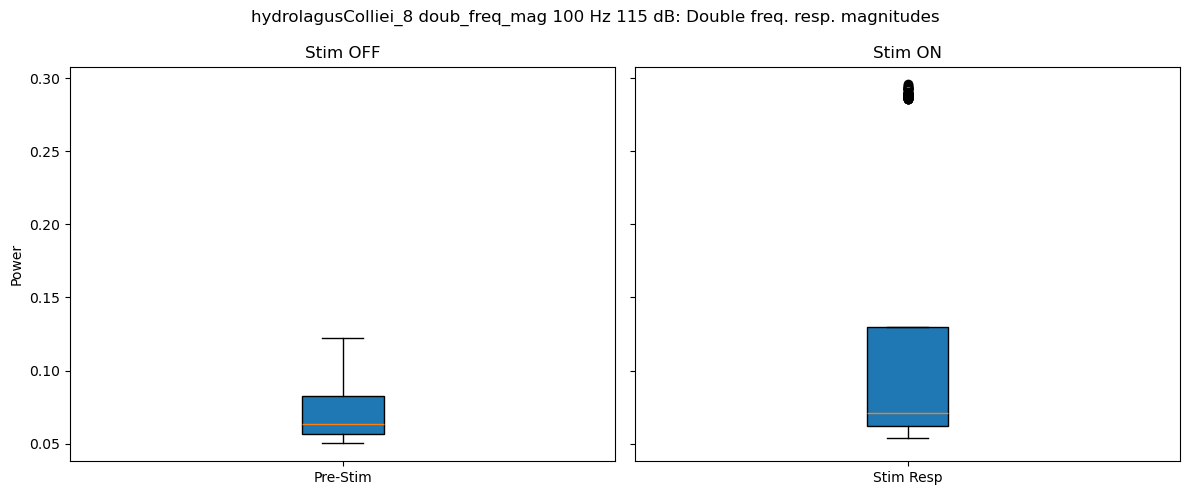

In [ ]:
plot_box_whisker(collapsed_data, subjid, myfreq, myamp, 'doub_freq_mag')

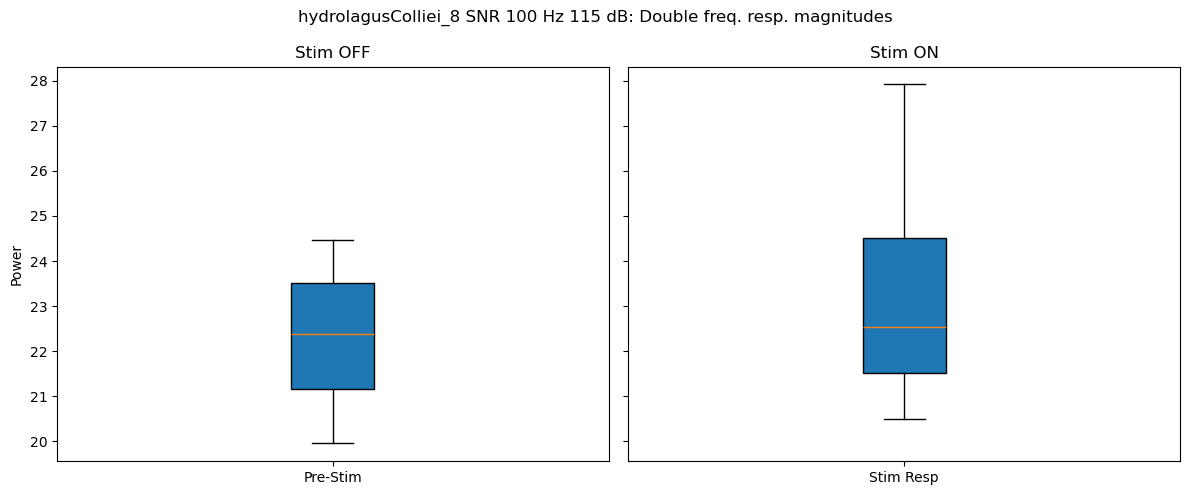

In [ ]:
plot_box_whisker(collapsed_data, subjid, myfreq, myamp, 'SNR')

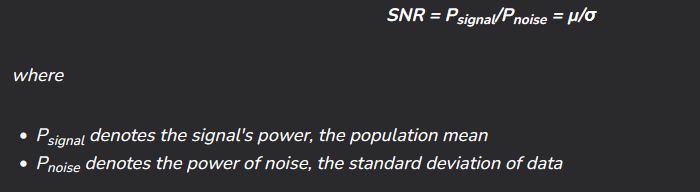

## STOP!

### T-test based hmmm not normal!

In [ ]:
from scipy import stats

### Valid to use t-tests on non normal data?? Hmm my data is super not normal so maybe not
t_stats = {channel: [] for channel in channel_keys}
p_vals = {channel: [] for channel in channel_keys}

for channel in channel_keys:
    for my_cum in range(len(stim_resp_doub_power[channel])):

        mean1 = stim_resp_doub_power[channel][my_cum]
        mean2 = pre_stim_doub_power[channel][my_cum]

        std1 = stim_resp_doub_power_std[channel][my_cum]
        std2 = pre_stim_doub_power_std[channel][my_cum]
        
        nobs1 = stimresp_cumulative_trials[channel][my_cum]
        nobs2 = prestim_cumulative_trials[channel][my_cum]

        # Perform the t-test
        t_statistic, p_value = stats.ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=nobs1,
                                                        mean2=mean2, std2=std2, nobs2=nobs2)
        
        t_stats[channel].append(t_statistic)
        p_vals[channel].append(p_value)

NameError: name 'stim_resp_doub_power' is not defined

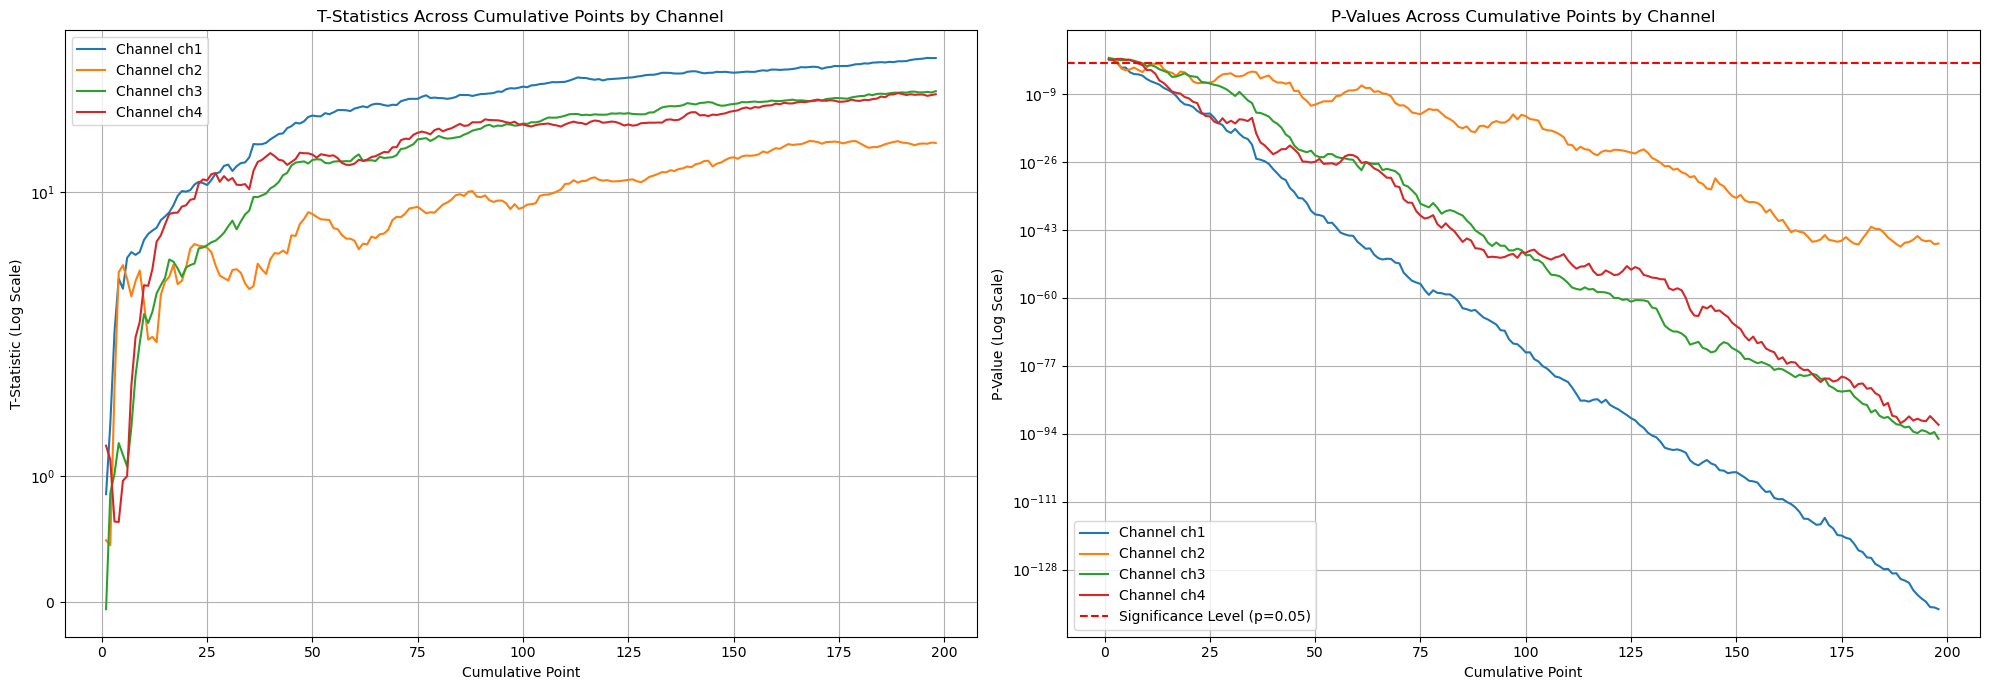

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with side-by-side subplots
plt.figure(figsize=(20, 7))

# Subplot for t-statistics (log scale)
plt.subplot(1, 2, 1)
plt.title('T-Statistics Across Cumulative Points by Channel')
plt.xlabel('Cumulative Point')
plt.ylabel('T-Statistic (Log Scale)')
plt.yscale('symlog')  # Symmetric log scale to handle negative and positive values
for channel in channel_keys:
    plt.plot(t_stats[channel], label=f'Channel {channel}')
plt.legend()
plt.grid(True)

# Subplot for p-values (log scale)
plt.subplot(1, 2, 2)
plt.title('P-Values Across Cumulative Points by Channel')
plt.xlabel('Cumulative Point')
plt.ylabel('P-Value (Log Scale)')
plt.yscale('log')
for channel in channel_keys:
    plt.plot(p_vals[channel], label=f'Channel {channel}')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (p=0.05)')
plt.legend()
plt.grid(True)

fig.suptitle(f"T-Test Results: {myfreq}Hz {myamp}dB")

plt.tight_layout()
plt.savefig(f"{subjid}_t_test_lineplot_{myfreq}Hz_{myamp}dB.png", 
            format='png', 
            bbox_inches='tight', 
            dpi=300)
plt.show()

### Learnings about t-test and normality


### Check for normality

In [ ]:
data = stimresp_cumulative[channel]  # shape (n_trials, n_timepoints)

# Collapse each trial to a single representative value (e.g., mean or RMS power)
trial_means = np.sqrt(np.mean(data**2, axis=1))  # one value per trial

# Check normality of those trial-level values
shapiro_result = stats.shapiro(trial_means)
dagostino_result = stats.normaltest(trial_means)

print("Shapiro-Wilk p =", shapiro_result.pvalue)
print("D’Agostino-Pearson p =", dagostino_result.pvalue)

Shapiro-Wilk p = 2.060683807549366e-24
D’Agostino-Pearson p = 3.992147929019535e-54


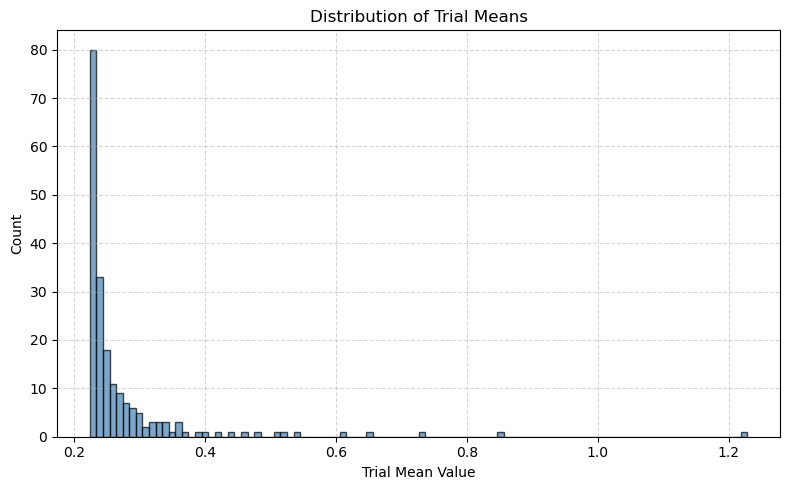

In [ ]:
# trial_means is a 1D NumPy array of your per-trial means or RMS values
# Example: trial_means = np.sqrt(np.mean(data**2, axis=1))

plt.figure(figsize=(8, 5))
plt.hist(trial_means, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Trial Means")
plt.xlabel("Trial Mean Value")
plt.ylabel("Count")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
